<a href="https://colab.research.google.com/github/danielgrgurevic/PortafolioDataScience/blob/main/SQM_forecast_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Proyecto predicciones valor de acciones de SQM con LSTM.


* Objetivo:

  - Predecer em un plazo de 6 meses los valores de las acciones para poder realizar una mejor gestión de cartera.

* Tareas:
 1- importar datos
 2- unir todo en un dataframe

  2.1 - comsiderar alineacion temporal

  2.2 - frecuencia de datos
  
  2.3 limpieza de datos


revisar colinealidad

# 1- Importación de Datos

## 1.1 Datos SQM

In [ ]:
!pip install fredapi

In [ ]:
import yfinance as yf
import pandas as pd

# Definición del ticker de SQM
sqm_ticker = 'SQM'

# Obtención de datos históricos de precios de SQM
sqm_data = yf.Ticker(sqm_ticker)
df_sqm = sqm_data.history(start="1994-01-01")
df_sqm = df_sqm.reset_index()

In [ ]:
# Convertir la columna 'fecha' al formato de fecha 'año-mes-día'
df_sqm['Date'] = pd.to_datetime(df_sqm['Date'], format='%Y %m %d')
df_sqm['Date'] = df_sqm['Date'].dt.strftime('%Y %m %d')

In [ ]:
df_sqm['Date'] = pd.to_datetime(df_sqm['Date'], format='%Y %m %d')

In [ ]:
df_sqm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7641 entries, 0 to 7640
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          7641 non-null   datetime64[ns]
 1   Open          7641 non-null   float64       
 2   High          7641 non-null   float64       
 3   Low           7641 non-null   float64       
 4   Close         7641 non-null   float64       
 5   Volume        7641 non-null   int64         
 6   Dividends     7641 non-null   float64       
 7   Stock Splits  7641 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 477.7 KB


In [ ]:
df_sqm

Date       Open       High        Low      Close   Volume  \
0    1994-01-03   1.151877   1.175874   1.142278   1.166275   960245   
1    1994-01-04   1.161475   1.161475   1.142277   1.151876   413881   
2    1994-01-05   1.151877   1.161475   1.123079   1.147077   610038   
3    1994-01-06   1.151877   1.151877   1.118281   1.118281   115024   
4    1994-01-07   1.118280   1.118280   1.094283   1.094283   218751   
...         ...        ...        ...        ...        ...      ...   
7636 2024-05-02  46.599998  47.200001  45.549999  46.700001   723700   
7637 2024-05-03  47.860001  48.470001  47.590000  47.680000   835400   
7638 2024-05-06  48.450001  48.580002  47.619999  47.959999   622400   
7639 2024-05-07  47.619999  48.849998  47.500000  48.009998   803100   
7640 2024-05-08  47.240002  47.959999  46.680000  47.700001  1115276   

      Dividends  Stock Splits  
0           0.0           0.0  
1           0.0           0.0  
2           0.0           0.0  
3           0.0           0.0  
4           0.0           0.0  
...         ...           ...  
7636        0.0           0.0  
7637        0.0           0.0  
7638        0.0           0.0  
7639        0.0           0.0  
7640        0.0           0.0  

[7641 rows x 8 columns]

## 1.2 tasa del tesoro a 3 meses

In [ ]:
# Definición del ticker para la tasa de fondos federales efectiva diaria
ticker = '^IRX'  # Este es el símbolo para la tasa del Tesoro a 3 meses, ajusta según la tasa que te interese

# Obtención de datos históricos de precios de este indicador
data = yf.Ticker(ticker)
df_tasa_diaria = data.history(period="max")  # Cambia 'max' por las fechas específicas si es necesario

# Filtrar datos desde una fecha específica, por ejemplo, desde 1994
df_tasa_diaria = df_tasa_diaria.loc['1994-01-01':]

In [ ]:
# Sacar Date del índice y volverlo una columna
df_tasa_diaria.reset_index(inplace=True)
df_tasa_diaria['Date'] = df_tasa_diaria['Date'].dt.strftime('%Y %m %d')
df_tasa_diaria['Date'] = pd.to_datetime(df_tasa_diaria['Date'], format='%Y %m %d')

In [ ]:
df_tasa_diaria.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7622 entries, 0 to 7621
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          7622 non-null   datetime64[ns]
 1   Open          7622 non-null   float64       
 2   High          7622 non-null   float64       
 3   Low           7622 non-null   float64       
 4   Close         7622 non-null   float64       
 5   Volume        7622 non-null   int64         
 6   Dividends     7622 non-null   float64       
 7   Stock Splits  7622 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 476.5 KB


In [ ]:
df_tasa_diaria

Date   Open   High    Low  Close  Volume  Dividends  Stock Splits
0    1994-01-03  3.010  3.040  3.010  3.030       0        0.0           0.0
1    1994-01-04  3.090  3.090  3.070  3.080       0        0.0           0.0
2    1994-01-05  3.080  3.080  3.060  3.070       0        0.0           0.0
3    1994-01-06  3.060  3.060  3.040  3.050       0        0.0           0.0
4    1994-01-07  3.040  3.040  3.010  3.010       0        0.0           0.0
...         ...    ...    ...    ...    ...     ...        ...           ...
7617 2024-05-02  5.243  5.243  5.238  5.238       0        0.0           0.0
7618 2024-05-03  5.238  5.238  5.223  5.235       0        0.0           0.0
7619 2024-05-06  5.238  5.243  5.235  5.240       0        0.0           0.0
7620 2024-05-07  5.240  5.243  5.240  5.243       0        0.0           0.0
7621 2024-05-08  5.245  5.245  5.245  5.245       0        0.0           0.0

[7622 rows x 8 columns]

2. indicadores sectoriales, precios de commodities

In [ ]:
import yfinance as yf

# Ejemplo para obtener el precio de commodities que están disponibles en forma de ETF o fondos negociables en bolsa
cobre_etf = yf.download("COPX", start="1994-01-01")  # ETF de cobre

# Ejemplo para descargar datos del ETF de oro
gold_etf = yf.download("GLD", start="2004-01-01")

# Ejemplo para descargar datos del ETF que sigue el precio del petróleo
oil_etf = yf.download("USO", start="2007-01-01")

#natural_gas_etf = yf.download("UNG", start="2007-01-01")  # UNG empezó en 2007

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
cobre_etf

Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2010-04-20  44.700001  44.700001  43.950001  44.040001  32.777866     1933
2010-04-21  43.799999  44.099998  43.230000  43.349998  32.264320     2900
2010-04-22  43.169998  43.169998  42.509998  43.110001  32.085693     3600
2010-04-23  42.959999  43.259998  42.750000  43.259998  32.197338     1100
2010-04-26  44.880001  44.880001  43.200001  43.919998  32.688549     3600
...               ...        ...        ...        ...        ...      ...
2024-05-02  45.770000  46.099998  45.029999  45.700001  45.700001   729300
2024-05-03  46.340000  46.720001  45.990002  46.639999  46.639999   664300
2024-05-06  47.000000  47.400002  47.000000  47.349998  47.349998   623300
2024-05-07  47.450001  47.529999  47.009998  47.410000  47.410000  1358600
2024-05-08  46.750000  47.009998  46.343800  46.799999  46.799999   810681

[3538 rows x 6 columns]

In [ ]:
gold_etf

Open        High         Low       Close   Adj Close  \
Date                                                                     
2004-11-18   44.430000   44.490002   44.070000   44.380001   44.380001   
2004-11-19   44.490002   44.919998   44.470001   44.779999   44.779999   
2004-11-22   44.750000   44.970001   44.740002   44.950001   44.950001   
2004-11-23   44.880001   44.919998   44.720001   44.750000   44.750000   
2004-11-24   44.930000   45.049999   44.790001   45.049999   45.049999   
...                ...         ...         ...         ...         ...   
2024-05-02  211.899994  213.710007  211.490005  213.130005  213.130005   
2024-05-03  212.889999  213.229996  210.710007  212.960007  212.960007   
2024-05-06  215.139999  215.910004  214.470001  215.199997  215.199997   
2024-05-07  214.520004  214.929993  213.880005  214.210007  214.210007   
2024-05-08  213.619995  214.800003  213.529999  213.580002  213.580002   

              Volume  
Date                  
2004-11-18   5992000  
2004-11-19  11655300  
2004-11-22  11996000  
2004-11-23   3169200  
2004-11-24   6105100  
...              ...  
2024-05-02   6287000  
2024-05-03   8679900  
2024-05-06   6840500  
2024-05-07   5660700  
2024-05-08   4418725  

[4900 rows x 6 columns]

In [ ]:
oil_etf

Open        High         Low       Close   Adj Close  \
Date                                                                     
2007-01-03  411.359985  411.359985  393.040009  395.200012  395.200012   
2007-01-04  388.320007  391.200012  377.760010  379.119995  379.119995   
2007-01-05  379.200012  383.440002  375.119995  382.640015  382.640015   
2007-01-08  389.760010  392.399994  376.000000  379.920013  379.920013   
2007-01-09  370.160004  380.000000  369.440002  378.399994  378.399994   
...                ...         ...         ...         ...         ...   
2024-05-02   76.099998   76.400002   75.370003   75.930000   75.930000   
2024-05-03   75.739998   75.919998   75.019997   75.129997   75.129997   
2024-05-06   75.540001   75.980003   74.959999   75.660004   75.660004   
2024-05-07   75.250000   76.160004   74.639999   75.500000   75.500000   
2024-05-08   74.720001   76.180000   74.550003   76.110001   76.110001   

             Volume  
Date                 
2007-01-03   401713  
2007-01-04   557488  
2007-01-05   454100  
2007-01-08   493650  
2007-01-09   502463  
...             ...  
2024-05-02  4710000  
2024-05-03  2875100  
2024-05-06  6195900  
2024-05-07  4327400  
2024-05-08  2410185  

[4367 rows x 6 columns]

In [ ]:
import yfinance as yf

# Obtener datos del índice Shanghai Composite
shanghai_comp = yf.Ticker("000001.SS")
data_shanghai = shanghai_comp.history(period="max")
data_shanghai

Open         High          Low        Close  \
Date                                                                            
1997-07-02 00:00:00+08:00  1255.909058  1261.571045  1147.331055  1199.061035   
1997-07-03 00:00:00+08:00  1194.676025  1194.676025  1149.939941  1150.623047   
1997-07-04 00:00:00+08:00  1138.921021  1163.249023  1124.776001  1159.342041   
1997-07-07 00:00:00+08:00  1161.707031  1163.447021  1085.572021  1096.818970   
1997-07-08 00:00:00+08:00  1092.798950  1115.432983  1066.043945  1109.666016   
...                                ...          ...          ...          ...   
2024-04-29 00:00:00+08:00  3086.681885  3119.686035  3080.585938  3113.042969   
2024-04-30 00:00:00+08:00  3110.158936  3123.288086  3104.293945  3104.824951   
2024-05-06 00:00:00+08:00  3132.511963  3142.382080  3126.769043  3140.719971   
2024-05-07 00:00:00+08:00  3139.664062  3151.218994  3133.689941  3147.738037   
2024-05-08 00:00:00+08:00  3141.487305  3144.985596  3126.172852  3128.479736   

                               Volume  Dividends  Stock Splits  
Date                                                            
1997-07-02 00:00:00+08:00           0        0.0           0.0  
1997-07-03 00:00:00+08:00           0        0.0           0.0  
1997-07-04 00:00:00+08:00           0        0.0           0.0  
1997-07-07 00:00:00+08:00           0        0.0           0.0  
1997-07-08 00:00:00+08:00           0        0.0           0.0  
...                               ...        ...           ...  
2024-04-29 00:00:00+08:00      506900        0.0           0.0  
2024-04-30 00:00:00+08:00      440200        0.0           0.0  
2024-05-06 00:00:00+08:00      450700        0.0           0.0  
2024-05-07 00:00:00+08:00      379100        0.0           0.0  
2024-05-08 00:00:00+08:00  3335260928        0.0           0.0  

[6502 rows x 7 columns]

## 1.3 Datos del Mercado Financiero (S&P 500, NASDAQ, VIX)

In [ ]:
# Obtener datos del S&P 500
sp500 = yf.download("^GSPC", start="1994-01-01")

# Obtener datos del NASDAQ
nasdaq = yf.download("^IXIC", start="1994-01-01")

# Obtener datos del VIX
vix = yf.download("^VIX", start="1994-01-01")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
# Sacar Date del índice y volverlo una columna
sp500.reset_index(inplace=True)

In [ ]:
sp500.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7641 entries, 0 to 7640
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       7641 non-null   datetime64[ns]
 1   Open       7641 non-null   float64       
 2   High       7641 non-null   float64       
 3   Low        7641 non-null   float64       
 4   Close      7641 non-null   float64       
 5   Adj Close  7641 non-null   float64       
 6   Volume     7641 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 418.0 KB


In [ ]:
sp500

Date         Open         High          Low        Close  \
0    1994-01-03   466.510010   466.940002   464.359985   465.440002   
1    1994-01-04   465.440002   466.890015   464.440002   466.890015   
2    1994-01-05   466.890015   467.820007   465.920013   467.549988   
3    1994-01-06   467.549988   469.000000   467.019989   467.119995   
4    1994-01-07   467.089996   470.260010   467.029999   469.899994   
...         ...          ...          ...          ...          ...   
7636 2024-05-02  5049.319824  5073.209961  5011.049805  5064.200195   
7637 2024-05-03  5122.779785  5139.120117  5101.220215  5127.790039   
7638 2024-05-06  5142.419922  5181.000000  5142.419922  5180.740234   
7639 2024-05-07  5187.200195  5200.229980  5178.959961  5187.700195   
7640 2024-05-08  5168.979980  5191.950195  5165.859863  5187.669922   

        Adj Close      Volume  
0      465.440002   270140000  
1      466.890015   326600000  
2      467.549988   400030000  
3      467.119995   365960000  
4      469.899994   324920000  
...           ...         ...  
7636  5064.200195  4381660000  
7637  5127.790039  3924990000  
7638  5180.740234  3683250000  
7639  5187.700195  3987890000  
7640  5187.669922  2091022000  

[7641 rows x 7 columns]

In [ ]:
# Sacar Date del índice y volverlo una columna
nasdaq.reset_index(inplace=True)

In [ ]:
nasdaq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7641 entries, 0 to 7640
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       7641 non-null   datetime64[ns]
 1   Open       7641 non-null   float64       
 2   High       7641 non-null   float64       
 3   Low        7641 non-null   float64       
 4   Close      7641 non-null   float64       
 5   Adj Close  7641 non-null   float64       
 6   Volume     7641 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 418.0 KB


In [ ]:
nasdaq

Date          Open          High           Low         Close  \
0    1994-01-03    774.109985    777.289978    768.409973    770.760010   
1    1994-01-04    771.429993    774.780029    771.020020    774.280029   
2    1994-01-05    775.229980    778.210022    773.690002    778.049988   
3    1994-01-06    780.359985    781.210022    778.250000    780.409973   
4    1994-01-07    779.289978    783.390015    778.200012    782.940002   
...         ...           ...           ...           ...           ...   
7636 2024-05-02  15758.110352  15862.790039  15604.730469  15840.959961   
7637 2024-05-03  16147.480469  16204.709961  16068.339844  16156.330078   
7638 2024-05-06  16208.540039  16350.080078  16197.860352  16349.250000   
7639 2024-05-07  16358.339844  16397.390625  16303.839844  16332.559570   
7640 2024-05-08  16226.099609  16341.646484  16226.067383  16302.755859   

         Adj Close      Volume  
0       770.760010   253020000  
1       774.280029   298600000  
2       778.049988   349880000  
3       780.409973   349210000  
4       782.940002   330060000  
...            ...         ...  
7636  15840.959961  4901610000  
7637  16156.330078  4887310000  
7638  16349.250000  4460130000  
7639  16332.559570  5041870000  
7640  16302.755859  4132825000  

[7641 rows x 7 columns]

In [ ]:
# Sacar Date del índice y volverlo una columna
vix.reset_index(inplace=True)

In [ ]:
vix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7641 entries, 0 to 7640
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       7641 non-null   datetime64[ns]
 1   Open       7641 non-null   float64       
 2   High       7641 non-null   float64       
 3   Low        7641 non-null   float64       
 4   Close      7641 non-null   float64       
 5   Adj Close  7641 non-null   float64       
 6   Volume     7641 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 418.0 KB


In [ ]:
vix

Date   Open   High    Low  Close  Adj Close  Volume
0    1994-01-03  11.28  13.42  11.28  12.57      12.57       0
1    1994-01-04  12.87  12.87  11.81  11.91      11.91       0
2    1994-01-05  11.47  11.47  10.37  10.94      10.94       0
3    1994-01-06  11.47  11.74  10.34  11.27      11.27       0
4    1994-01-07  11.47  12.14  10.00  10.96      10.96       0
...         ...    ...    ...    ...    ...        ...     ...
7636 2024-05-02  15.14  16.09  14.60  14.68      14.68       0
7637 2024-05-03  14.51  14.58  13.48  13.49      13.49       0
7638 2024-05-06  13.98  14.02  13.44  13.49      13.49       0
7639 2024-05-07  13.52  13.64  13.16  13.23      13.23       0
7640 2024-05-08  13.24  13.51  12.94  13.00      13.00       0

[7641 rows x 7 columns]

## 1.4 Unión de Dataframes

In [ ]:
df = pd.merge(df_sqm, df_tasa_diaria, on='Date', how = 'left', suffixes= ('_sqm', '_tasas'))

In [ ]:
df = pd.merge(df, sp500, on='Date', how = 'left', suffixes = ('', '_sp500'))
df = pd.merge(df, nasdaq, on='Date', how = 'left', suffixes = ('_sp500', '_nasdaq'))
df = pd.merge(df, vix, on='Date', how = 'left', suffixes = ('', '_vix') )

In [ ]:
df

Date   Open_sqm   High_sqm    Low_sqm  Close_sqm  Volume_sqm  \
0    1994-01-03   1.151877   1.175874   1.142278   1.166275      960245   
1    1994-01-04   1.161475   1.161475   1.142277   1.151876      413881   
2    1994-01-05   1.151877   1.161475   1.123079   1.147077      610038   
3    1994-01-06   1.151877   1.151877   1.118281   1.118281      115024   
4    1994-01-07   1.118280   1.118280   1.094283   1.094283      218751   
...         ...        ...        ...        ...        ...         ...   
7636 2024-05-02  46.599998  47.200001  45.549999  46.700001      723700   
7637 2024-05-03  47.860001  48.470001  47.590000  47.680000      835400   
7638 2024-05-06  48.450001  48.580002  47.619999  47.959999      622400   
7639 2024-05-07  47.619999  48.849998  47.500000  48.009998      803100   
7640 2024-05-08  47.240002  47.959999  46.680000  47.700001     1115276   

      Dividends_sqm  Stock Splits_sqm  Open_tasas  High_tasas  ...  \
0               0.0               0.0       3.010       3.040  ...   
1               0.0               0.0       3.090       3.090  ...   
2               0.0               0.0       3.080       3.080  ...   
3               0.0               0.0       3.060       3.060  ...   
4               0.0               0.0       3.040       3.040  ...   
...             ...               ...         ...         ...  ...   
7636            0.0               0.0       5.243       5.243  ...   
7637            0.0               0.0       5.238       5.238  ...   
7638            0.0               0.0       5.238       5.243  ...   
7639            0.0               0.0       5.240       5.243  ...   
7640            0.0               0.0       5.245       5.245  ...   

        Low_nasdaq  Close_nasdaq  Adj Close_nasdaq  Volume_nasdaq   Open  \
0       768.409973    770.760010        770.760010      253020000  11.28   
1       771.020020    774.280029        774.280029      298600000  12.87   
2       773.690002    778.049988        778.049988      349880000  11.47   
3       778.250000    780.409973        780.409973      349210000  11.47   
4       778.200012    782.940002        782.940002      330060000  11.47   
...            ...           ...               ...            ...    ...   
7636  15604.730469  15840.959961      15840.959961     4901610000  15.14   
7637  16068.339844  16156.330078      16156.330078     4887310000  14.51   
7638  16197.860352  16349.250000      16349.250000     4460130000  13.98   
7639  16303.839844  16332.559570      16332.559570     5041870000  13.52   
7640  16226.067383  16302.755859      16302.755859     4132825000  13.24   

       High    Low  Close  Adj Close  Volume  
0     13.42  11.28  12.57      12.57       0  
1     12.87  11.81  11.91      11.91       0  
2     11.47  10.37  10.94      10.94       0  
3     11.74  10.34  11.27      11.27       0  
4     12.14  10.00  10.96      10.96       0  
...     ...    ...    ...        ...     ...  
7636  16.09  14.60  14.68      14.68       0  
7637  14.58  13.48  13.49      13.49       0  
7638  14.02  13.44  13.49      13.49       0  
7639  13.64  13.16  13.23      13.23       0  
7640  13.51  12.94  13.00      13.00       0  

[7641 rows x 33 columns]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7641 entries, 0 to 7640
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                7641 non-null   datetime64[ns]
 1   Open_sqm            7641 non-null   float64       
 2   High_sqm            7641 non-null   float64       
 3   Low_sqm             7641 non-null   float64       
 4   Close_sqm           7641 non-null   float64       
 5   Volume_sqm          7641 non-null   int64         
 6   Dividends_sqm       7641 non-null   float64       
 7   Stock Splits_sqm    7641 non-null   float64       
 8   Open_tasas          7622 non-null   float64       
 9   High_tasas          7622 non-null   float64       
 10  Low_tasas           7622 non-null   float64       
 11  Close_tasas         7622 non-null   float64       
 12  Volume_tasas        7622 non-null   float64       
 13  Dividends_tasas     7622 non-null   float64     

In [ ]:
# Interpolar los valores faltantes
df.interpolate(inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7641 entries, 0 to 7640
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                7641 non-null   datetime64[ns]
 1   Open_sqm            7641 non-null   float64       
 2   High_sqm            7641 non-null   float64       
 3   Low_sqm             7641 non-null   float64       
 4   Close_sqm           7641 non-null   float64       
 5   Volume_sqm          7641 non-null   int64         
 6   Dividends_sqm       7641 non-null   float64       
 7   Stock Splits_sqm    7641 non-null   float64       
 8   Open_tasas          7641 non-null   float64       
 9   High_tasas          7641 non-null   float64       
 10  Low_tasas           7641 non-null   float64       
 11  Close_tasas         7641 non-null   float64       
 12  Volume_tasas        7641 non-null   float64       
 13  Dividends_tasas     7641 non-null   float64     

In [ ]:
df

Date   Open_sqm   High_sqm    Low_sqm  Close_sqm  Volume_sqm  \
0    1994-01-03   1.151877   1.175874   1.142278   1.166275      960245   
1    1994-01-04   1.161475   1.161475   1.142277   1.151876      413881   
2    1994-01-05   1.151877   1.161475   1.123079   1.147077      610038   
3    1994-01-06   1.151877   1.151877   1.118281   1.118281      115024   
4    1994-01-07   1.118280   1.118280   1.094283   1.094283      218751   
...         ...        ...        ...        ...        ...         ...   
7636 2024-05-02  46.599998  47.200001  45.549999  46.700001      723700   
7637 2024-05-03  47.860001  48.470001  47.590000  47.680000      835400   
7638 2024-05-06  48.450001  48.580002  47.619999  47.959999      622400   
7639 2024-05-07  47.619999  48.849998  47.500000  48.009998      803100   
7640 2024-05-08  47.240002  47.959999  46.680000  47.700001     1115276   

      Dividends_sqm  Stock Splits_sqm  Open_tasas  High_tasas  ...  \
0               0.0               0.0       3.010       3.040  ...   
1               0.0               0.0       3.090       3.090  ...   
2               0.0               0.0       3.080       3.080  ...   
3               0.0               0.0       3.060       3.060  ...   
4               0.0               0.0       3.040       3.040  ...   
...             ...               ...         ...         ...  ...   
7636            0.0               0.0       5.243       5.243  ...   
7637            0.0               0.0       5.238       5.238  ...   
7638            0.0               0.0       5.238       5.243  ...   
7639            0.0               0.0       5.240       5.243  ...   
7640            0.0               0.0       5.245       5.245  ...   

        Low_nasdaq  Close_nasdaq  Adj Close_nasdaq  Volume_nasdaq   Open  \
0       768.409973    770.760010        770.760010      253020000  11.28   
1       771.020020    774.280029        774.280029      298600000  12.87   
2       773.690002    778.049988        778.049988      349880000  11.47   
3       778.250000    780.409973        780.409973      349210000  11.47   
4       778.200012    782.940002        782.940002      330060000  11.47   
...            ...           ...               ...            ...    ...   
7636  15604.730469  15840.959961      15840.959961     4901610000  15.14   
7637  16068.339844  16156.330078      16156.330078     4887310000  14.51   
7638  16197.860352  16349.250000      16349.250000     4460130000  13.98   
7639  16303.839844  16332.559570      16332.559570     5041870000  13.52   
7640  16226.067383  16302.755859      16302.755859     4132825000  13.24   

       High    Low  Close  Adj Close  Volume  
0     13.42  11.28  12.57      12.57       0  
1     12.87  11.81  11.91      11.91       0  
2     11.47  10.37  10.94      10.94       0  
3     11.74  10.34  11.27      11.27       0  
4     12.14  10.00  10.96      10.96       0  
...     ...    ...    ...        ...     ...  
7636  16.09  14.60  14.68      14.68       0  
7637  14.58  13.48  13.49      13.49       0  
7638  14.02  13.44  13.49      13.49       0  
7639  13.64  13.16  13.23      13.23       0  
7640  13.51  12.94  13.00      13.00       0  

[7641 rows x 33 columns]

# 2. Exploración y Análisis de Datos

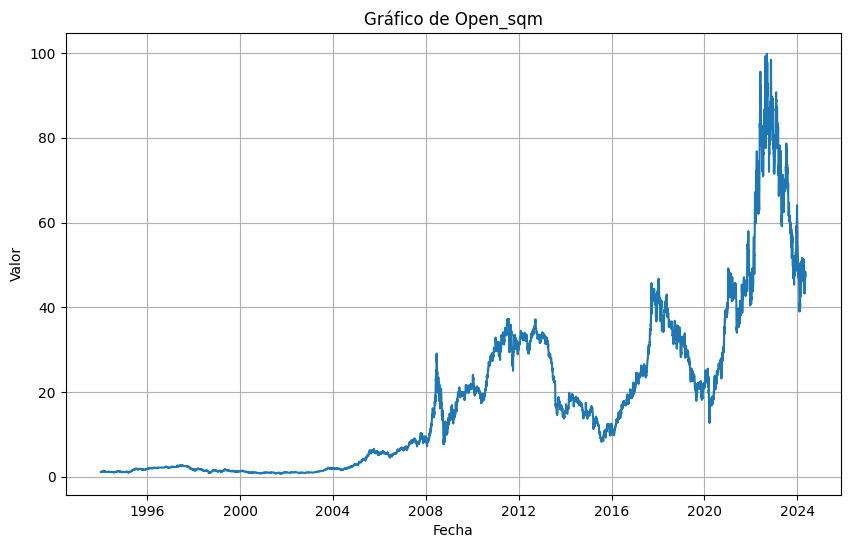

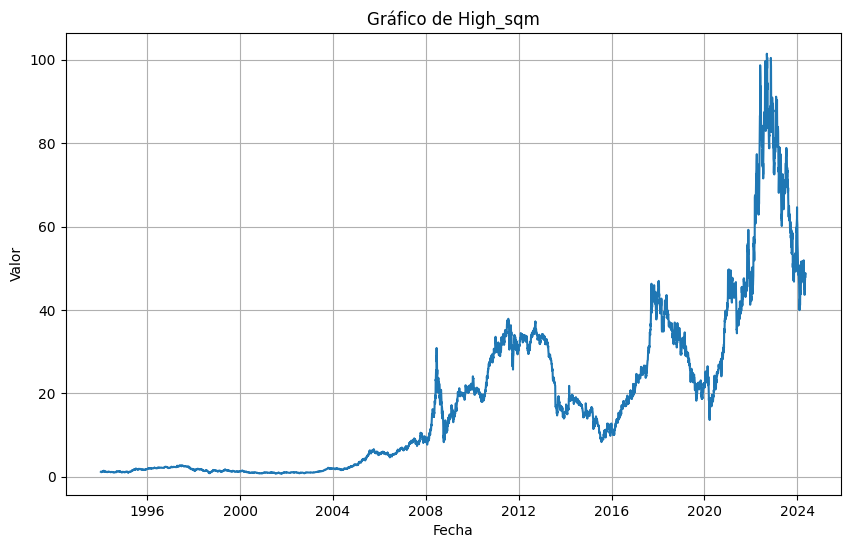

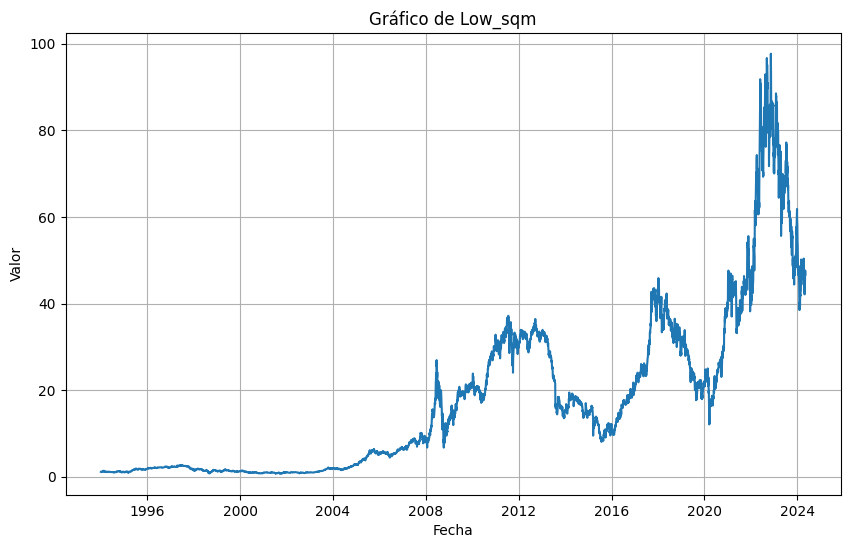

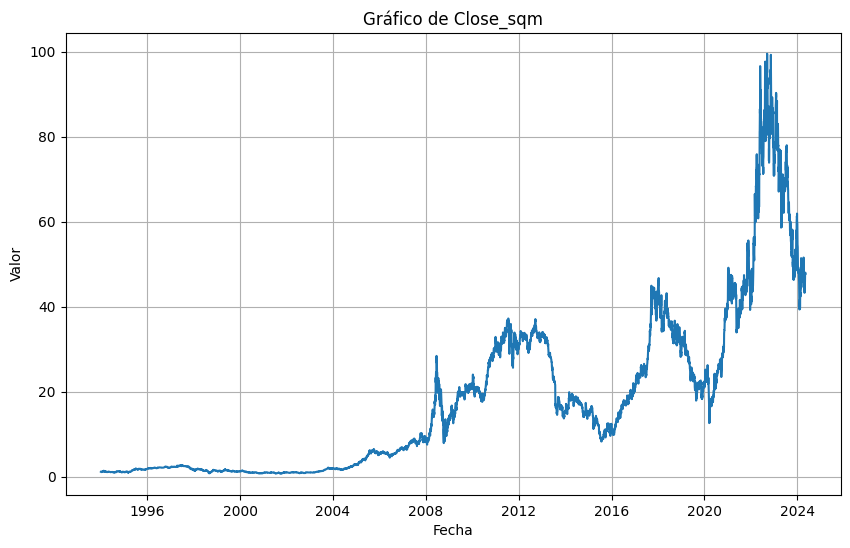

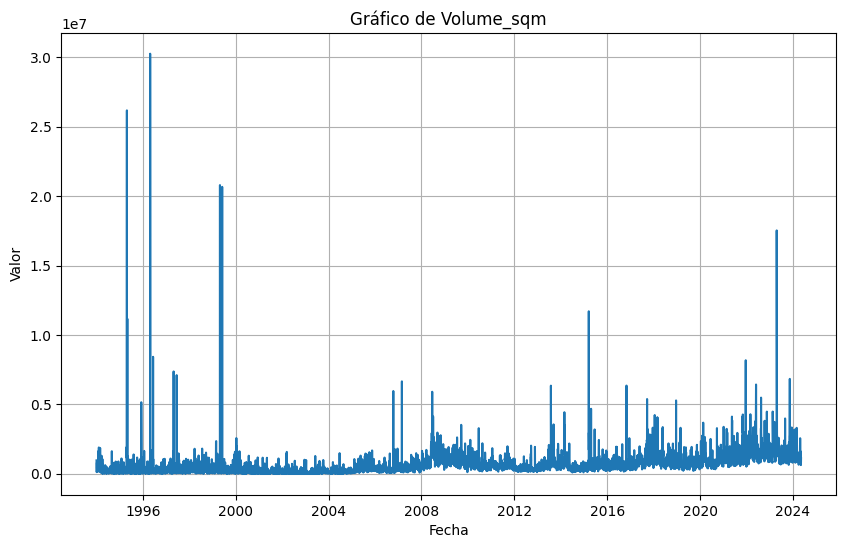

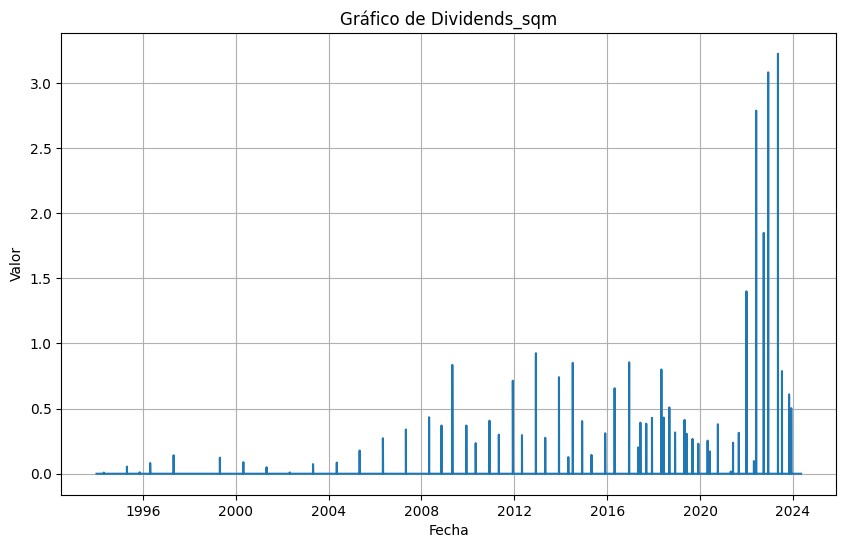

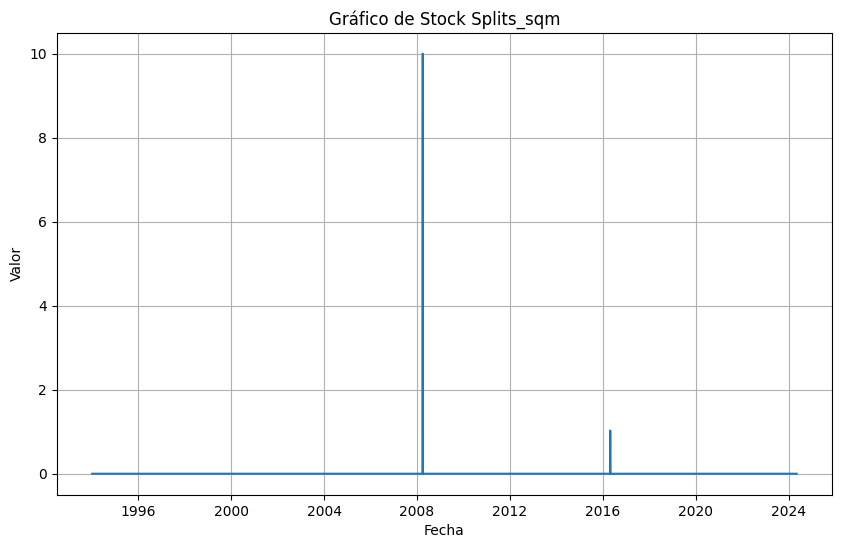

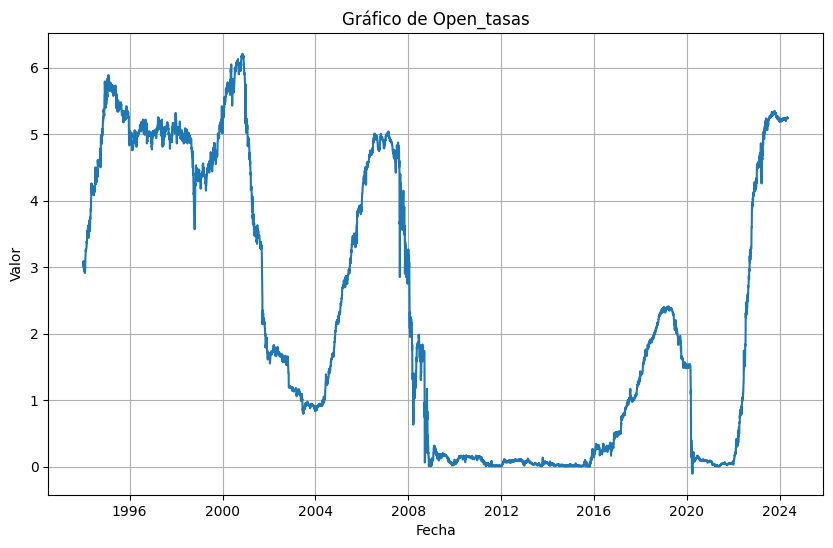

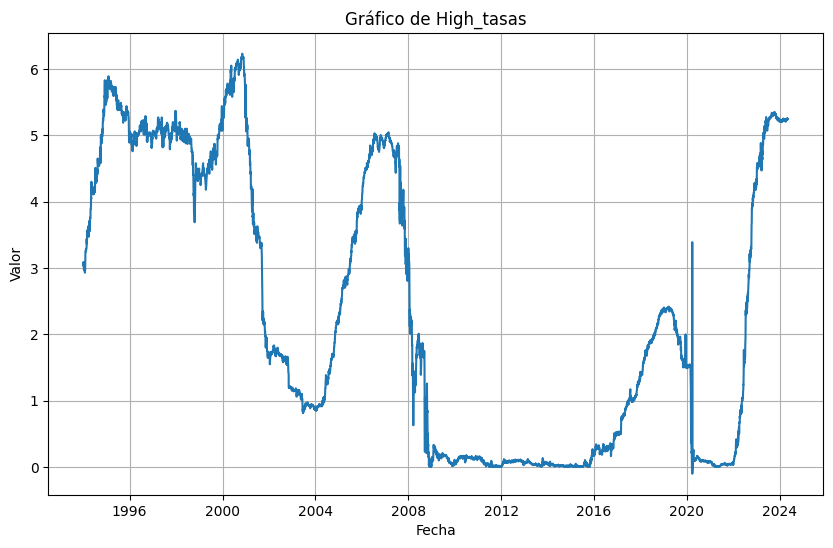

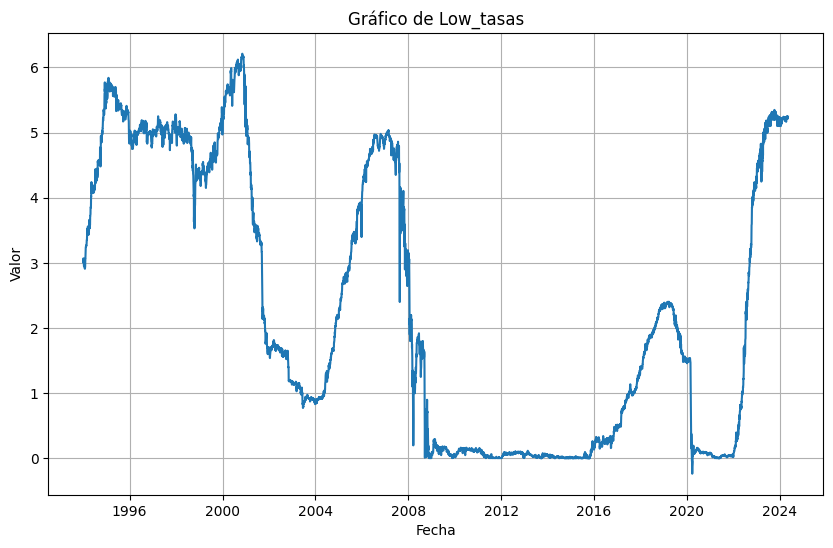

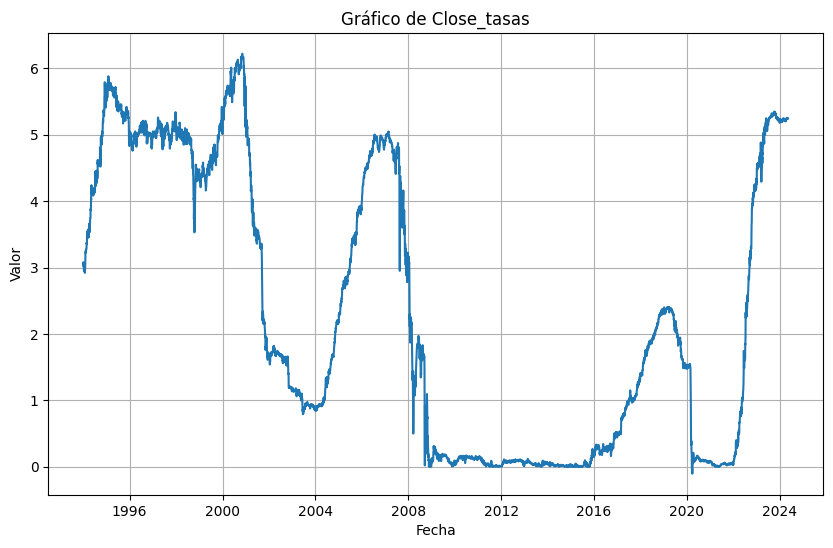

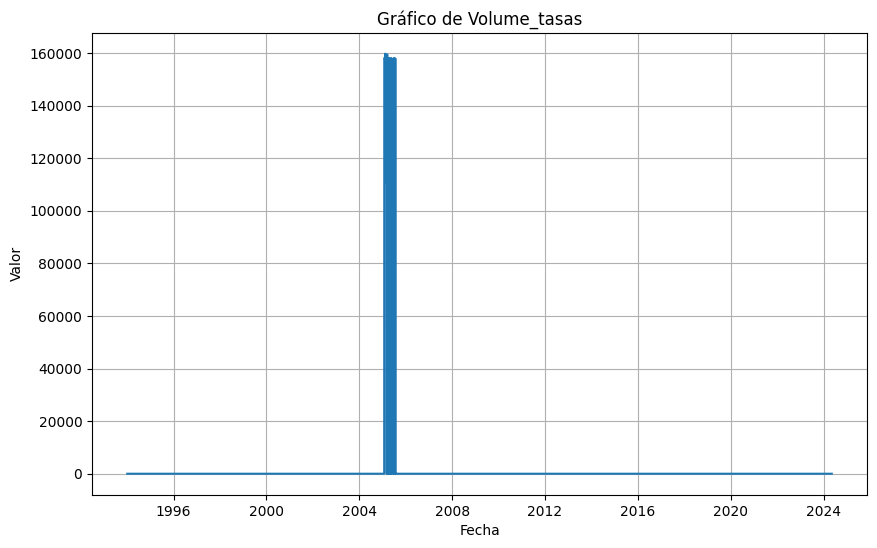

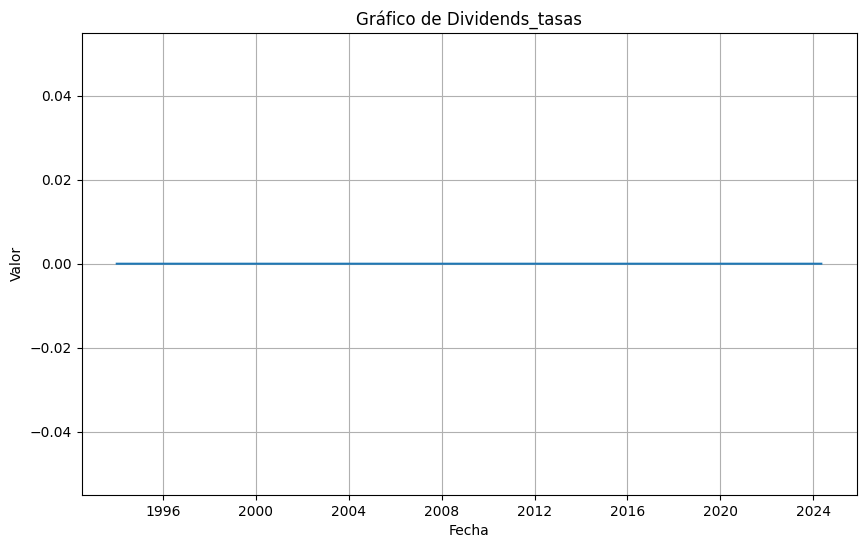

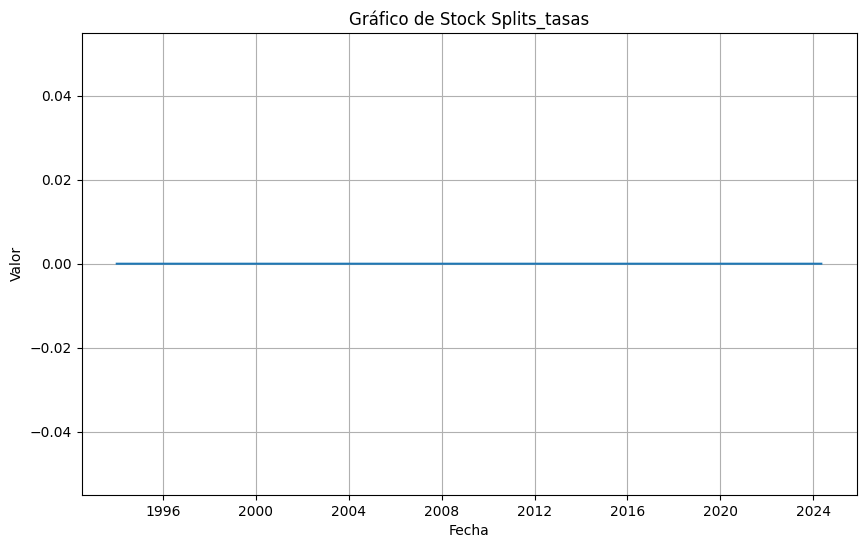

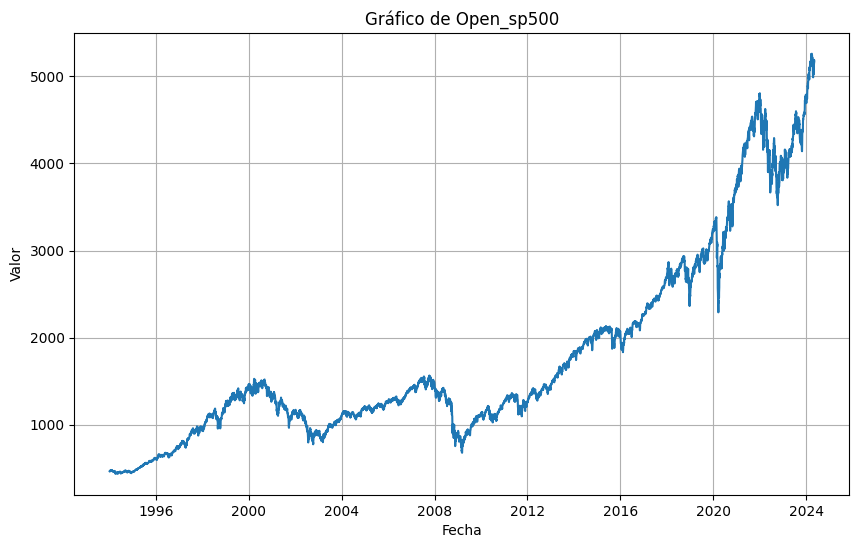

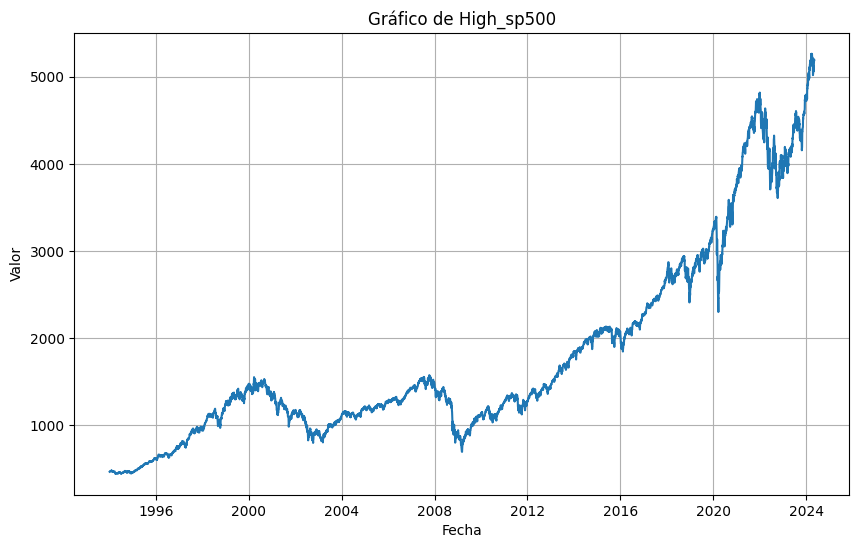

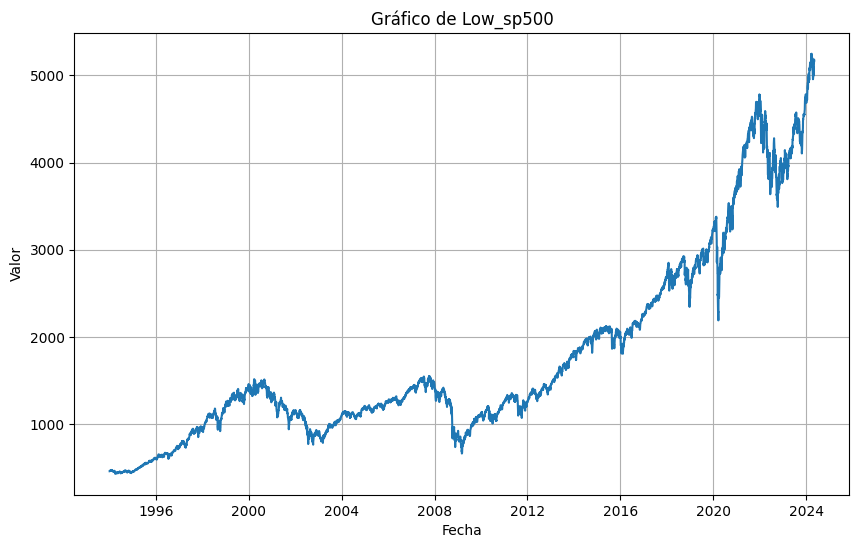

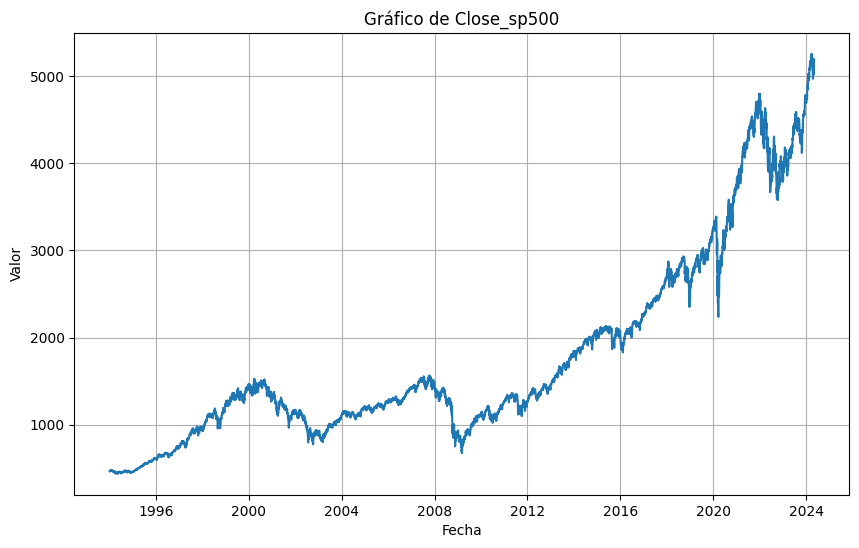

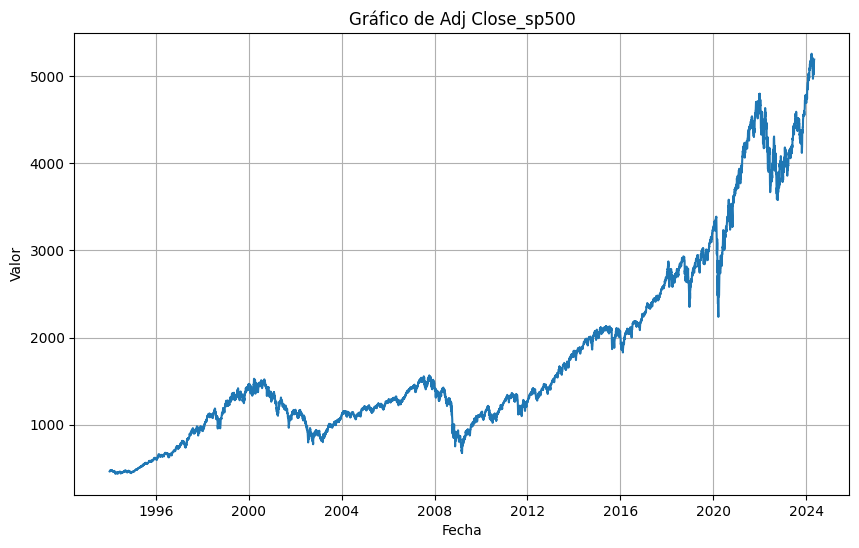

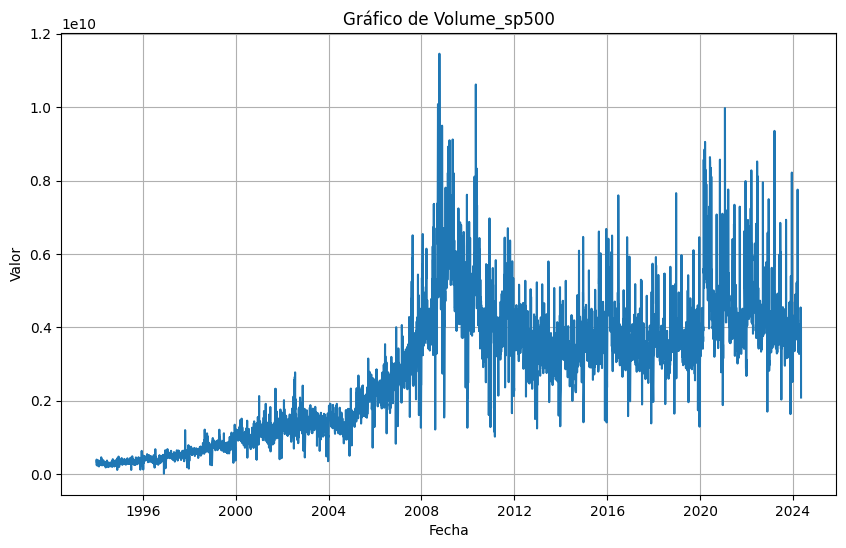

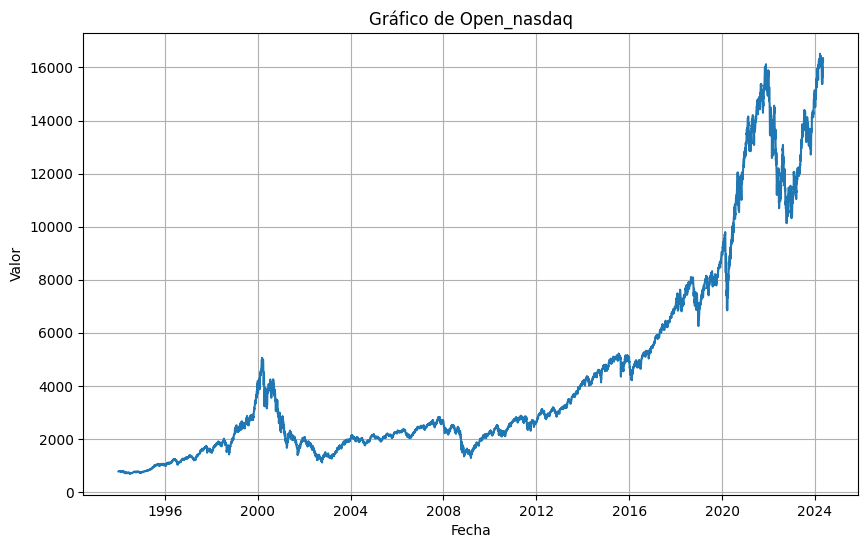

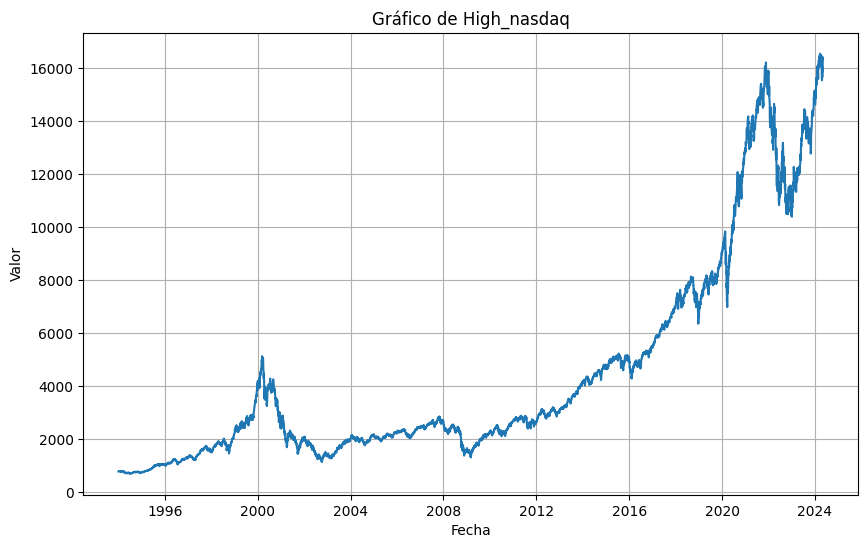

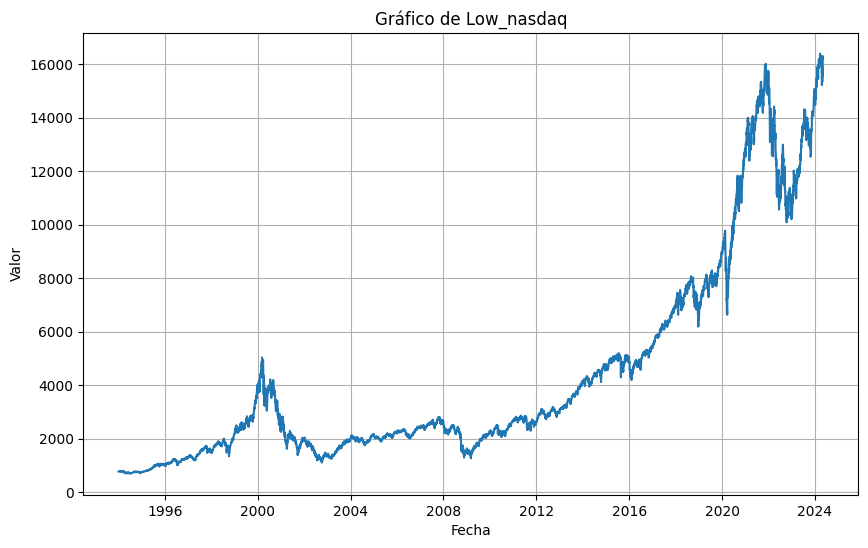

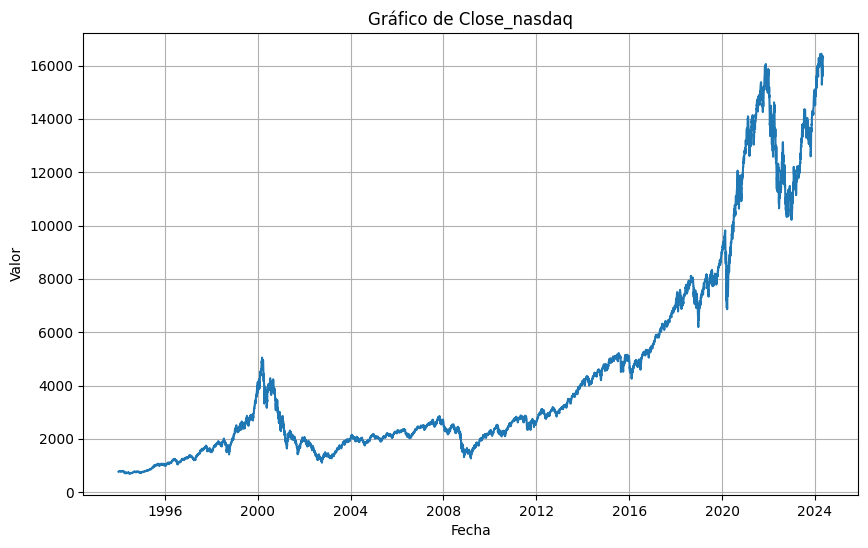

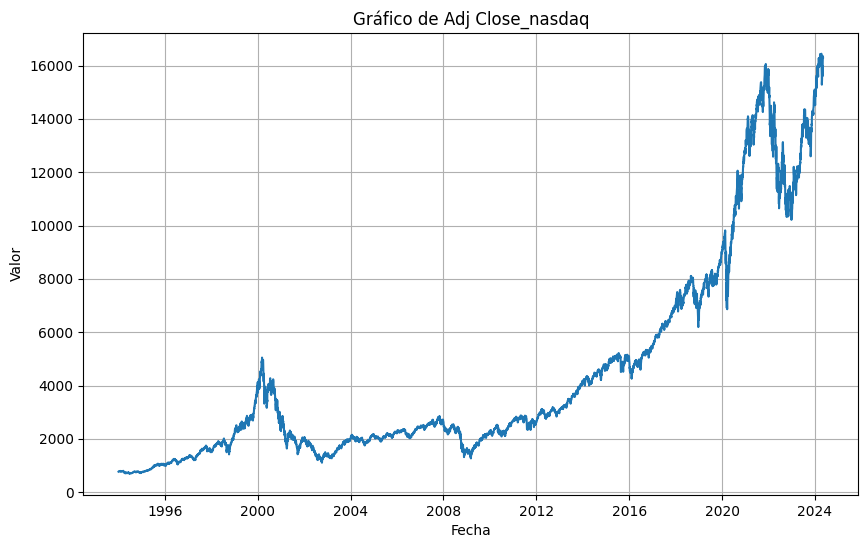

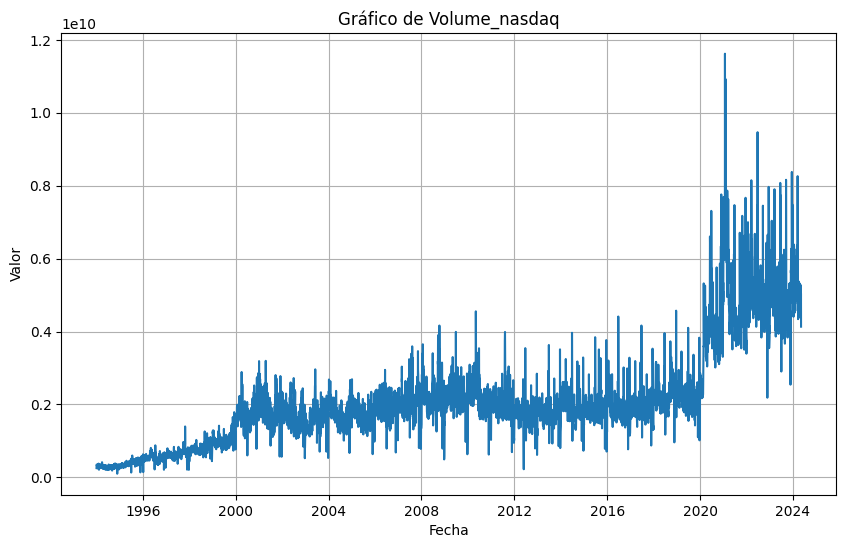

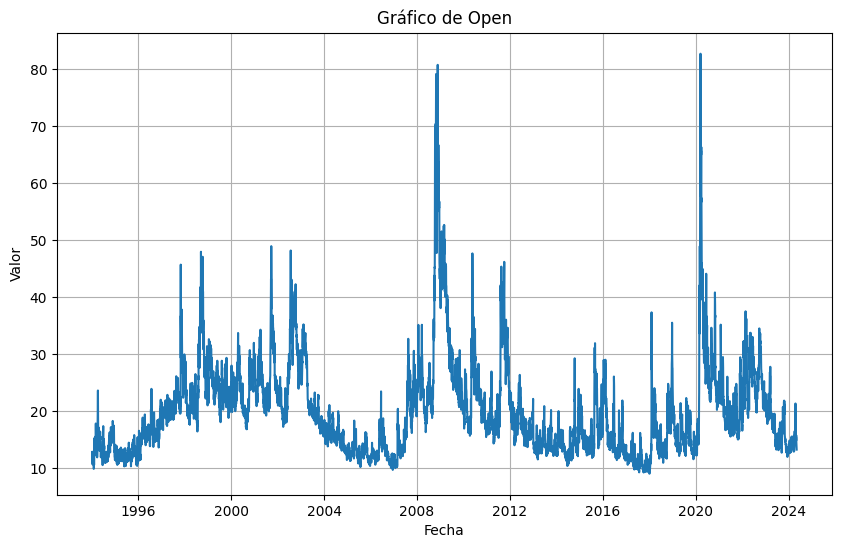

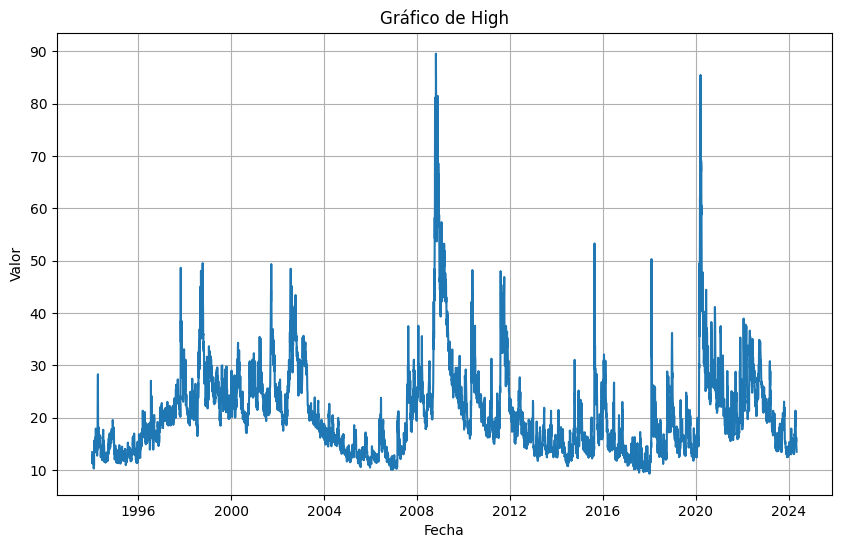

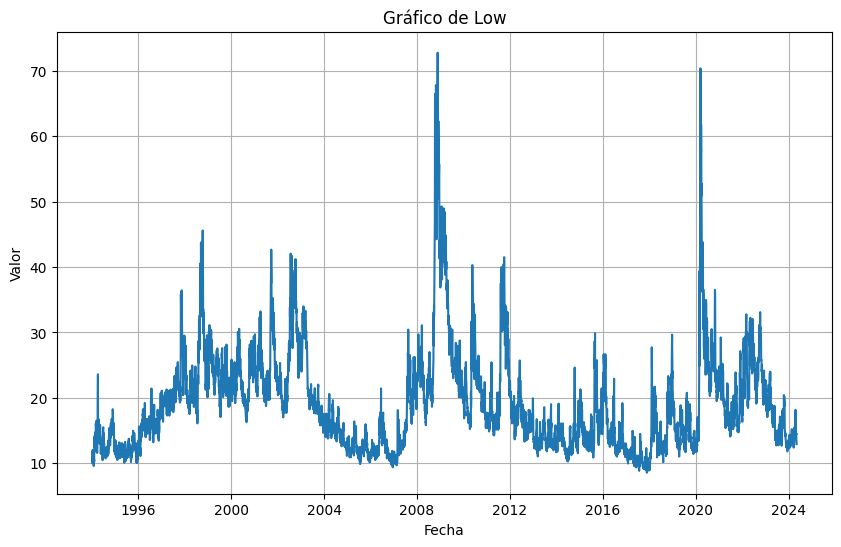

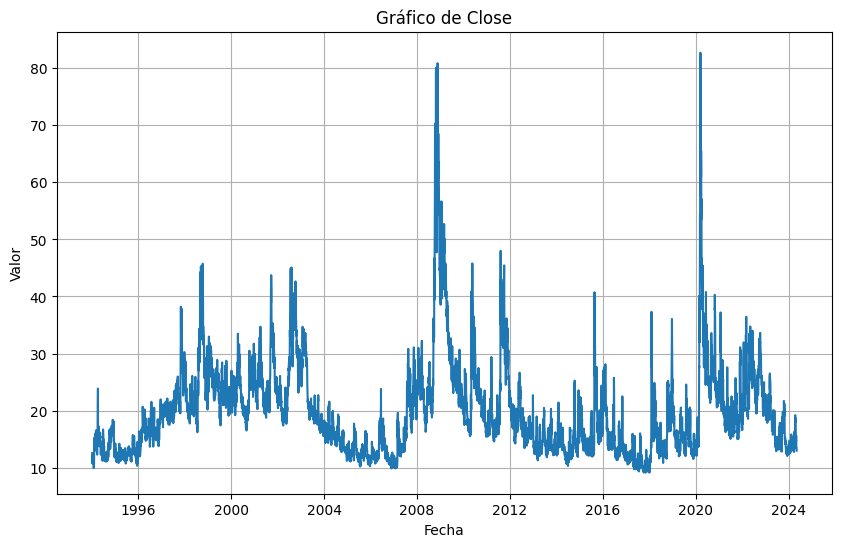

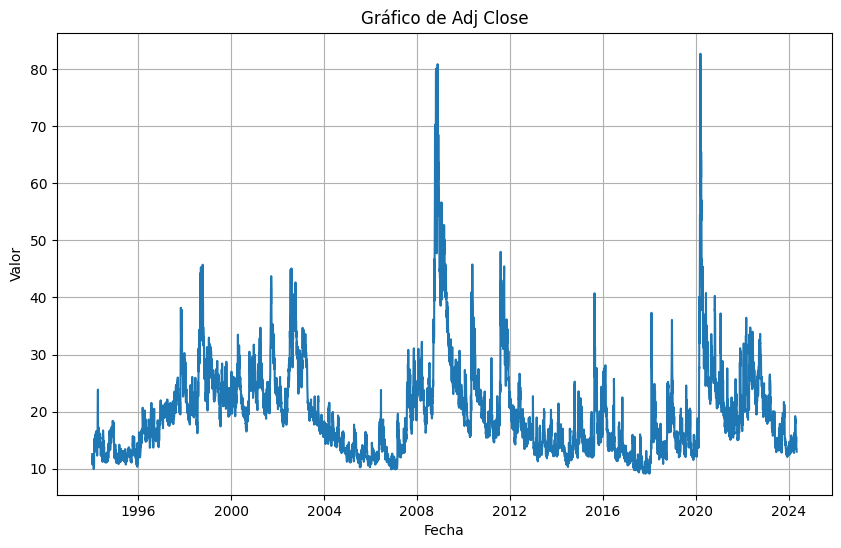

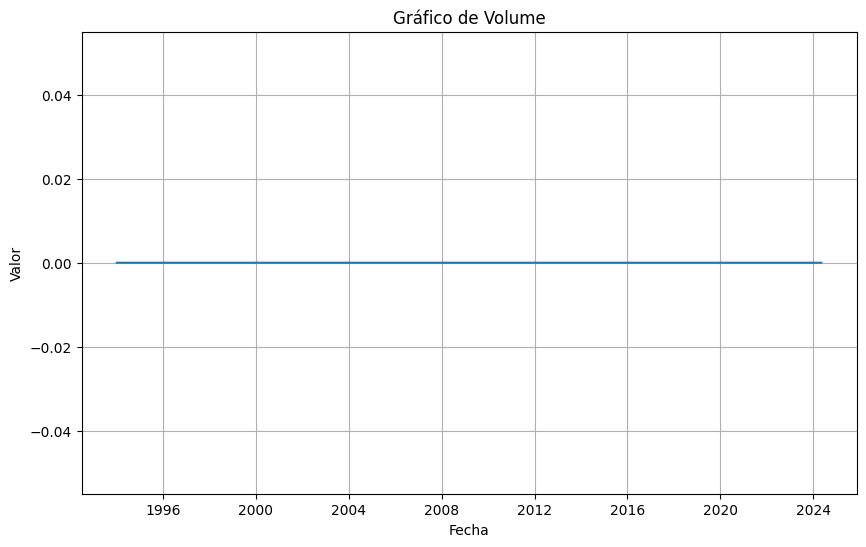

In [ ]:
import matplotlib.pyplot as plt

# Suponiendo que df es tu DataFrame resultante
# Iterar sobre cada columna del DataFrame excepto 'Date' y graficarla en un gráfico individual
for column in df.columns:
    if column != 'Date':
        plt.figure(figsize=(10, 6))  # Configurar el tamaño del gráfico
        plt.plot(df['Date'], df[column])  # Graficar la columna contra 'Date'
        plt.title(f'Gráfico de {column}')  # Configurar el título
        plt.xlabel('Fecha')  # Configurar la etiqueta del eje x
        plt.ylabel('Valor')  # Configurar la etiqueta del eje y
        plt.grid(True)  # Mostrar rejilla
        plt.show()  # Mostrar el gráfico



In [ ]:
# Lista de columnas a eliminar
columnas_a_eliminar = ['Dividends_tasas', 'Stock Splits_tasas', 'Volume']

# Eliminar las columnas de la lista
df = df.drop(columns=columnas_a_eliminar)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7641 entries, 0 to 7640
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              7641 non-null   datetime64[ns]
 1   Open_sqm          7641 non-null   float64       
 2   High_sqm          7641 non-null   float64       
 3   Low_sqm           7641 non-null   float64       
 4   Close_sqm         7641 non-null   float64       
 5   Volume_sqm        7641 non-null   int64         
 6   Dividends_sqm     7641 non-null   float64       
 7   Stock Splits_sqm  7641 non-null   float64       
 8   Open_tasas        7641 non-null   float64       
 9   High_tasas        7641 non-null   float64       
 10  Low_tasas         7641 non-null   float64       
 11  Close_tasas       7641 non-null   float64       
 12  Volume_tasas      7641 non-null   float64       
 13  Open_sp500        7641 non-null   float64       
 14  High_sp500        7641 n

In [ ]:
df.describe()

Date     Open_sqm     High_sqm      Low_sqm  \
count                           7641  7641.000000  7641.000000  7641.000000   
mean   2009-03-03 10:43:46.148409856    17.864825    18.145303    17.559416   
min              1994-01-03 00:00:00     0.715468     0.731217     0.713218   
25%              2001-07-27 00:00:00     1.788454     1.800904     1.777346   
50%              2009-03-05 00:00:00    12.177167    12.423874    11.933659   
75%              2016-10-04 00:00:00    28.803678    29.148377    28.427060   
max              2024-05-08 00:00:00    99.839913   101.435247    97.684875   
std                              NaN    19.625454    19.972007    19.227558   

         Close_sqm    Volume_sqm  Dividends_sqm  Stock Splits_sqm  \
count  7641.000000  7.641000e+03    7641.000000       7641.000000   
mean     17.849199  6.652544e+05       0.004078          0.001443   
min       0.719967  0.000000e+00       0.000000          0.000000   
25%       1.792668  2.095080e+05       0.000000          0.000000   
50%      12.164516  4.738000e+05       0.000000          0.000000   
75%      28.768133  8.794000e+05       0.000000          0.000000   
max      99.506813  3.025645e+07       3.224000         10.000000   
std      19.592005  9.177812e+05       0.074736          0.115000   

        Open_tasas   High_tasas  ...   High_nasdaq    Low_nasdaq  \
count  7641.000000  7641.000000  ...   7641.000000   7641.000000   
mean      2.334216     2.348172  ...   4428.990052   4363.012649   
min      -0.108000    -0.100000  ...    699.780029    690.950012   
25%       0.135000     0.140000  ...   1892.979980   1862.920044   
50%       1.707000     1.718000  ...   2612.370117   2567.879883   
75%       4.720000     4.740000  ...   5262.990234   5225.759766   
max       6.210000     6.230000  ...  16538.859375  16393.900391   
std       2.113646     2.119052  ...   3932.834381   3876.694491   

       Close_nasdaq  Adj Close_nasdaq  Volume_nasdaq         Open  \
count   7641.000000       7641.000000   7.641000e+03  7641.000000   
mean    4397.929770       4397.929770   2.082032e+09    19.922437   
min      693.789978        693.789978   9.859000e+07     9.010000   
25%     1878.520020       1878.520020   1.454550e+09    13.960000   
50%     2593.050049       2593.050049   1.861340e+09    18.129999   
75%     5244.569824       5244.569824   2.260950e+09    23.450001   
max    16442.199219      16442.199219   1.162119e+10    82.690002   
std     3906.626532       3906.626532   1.335713e+09     8.222797   

              High          Low        Close    Adj Close  
count  7641.000000  7641.000000  7641.000000  7641.000000  
mean     20.781472    19.095829    19.812118    19.812118  
min       9.310000     8.560000     9.140000     9.140000  
25%      14.560000    13.420000    13.880000    13.880000  
50%      18.889999    17.410000    18.040001    18.040001  
75%      24.410000    22.540001    23.340000    23.340000  
max      89.529999    72.760002    82.690002    82.690002  
std       8.719440     7.674843     8.149690     8.149690  

[8 rows x 30 columns]

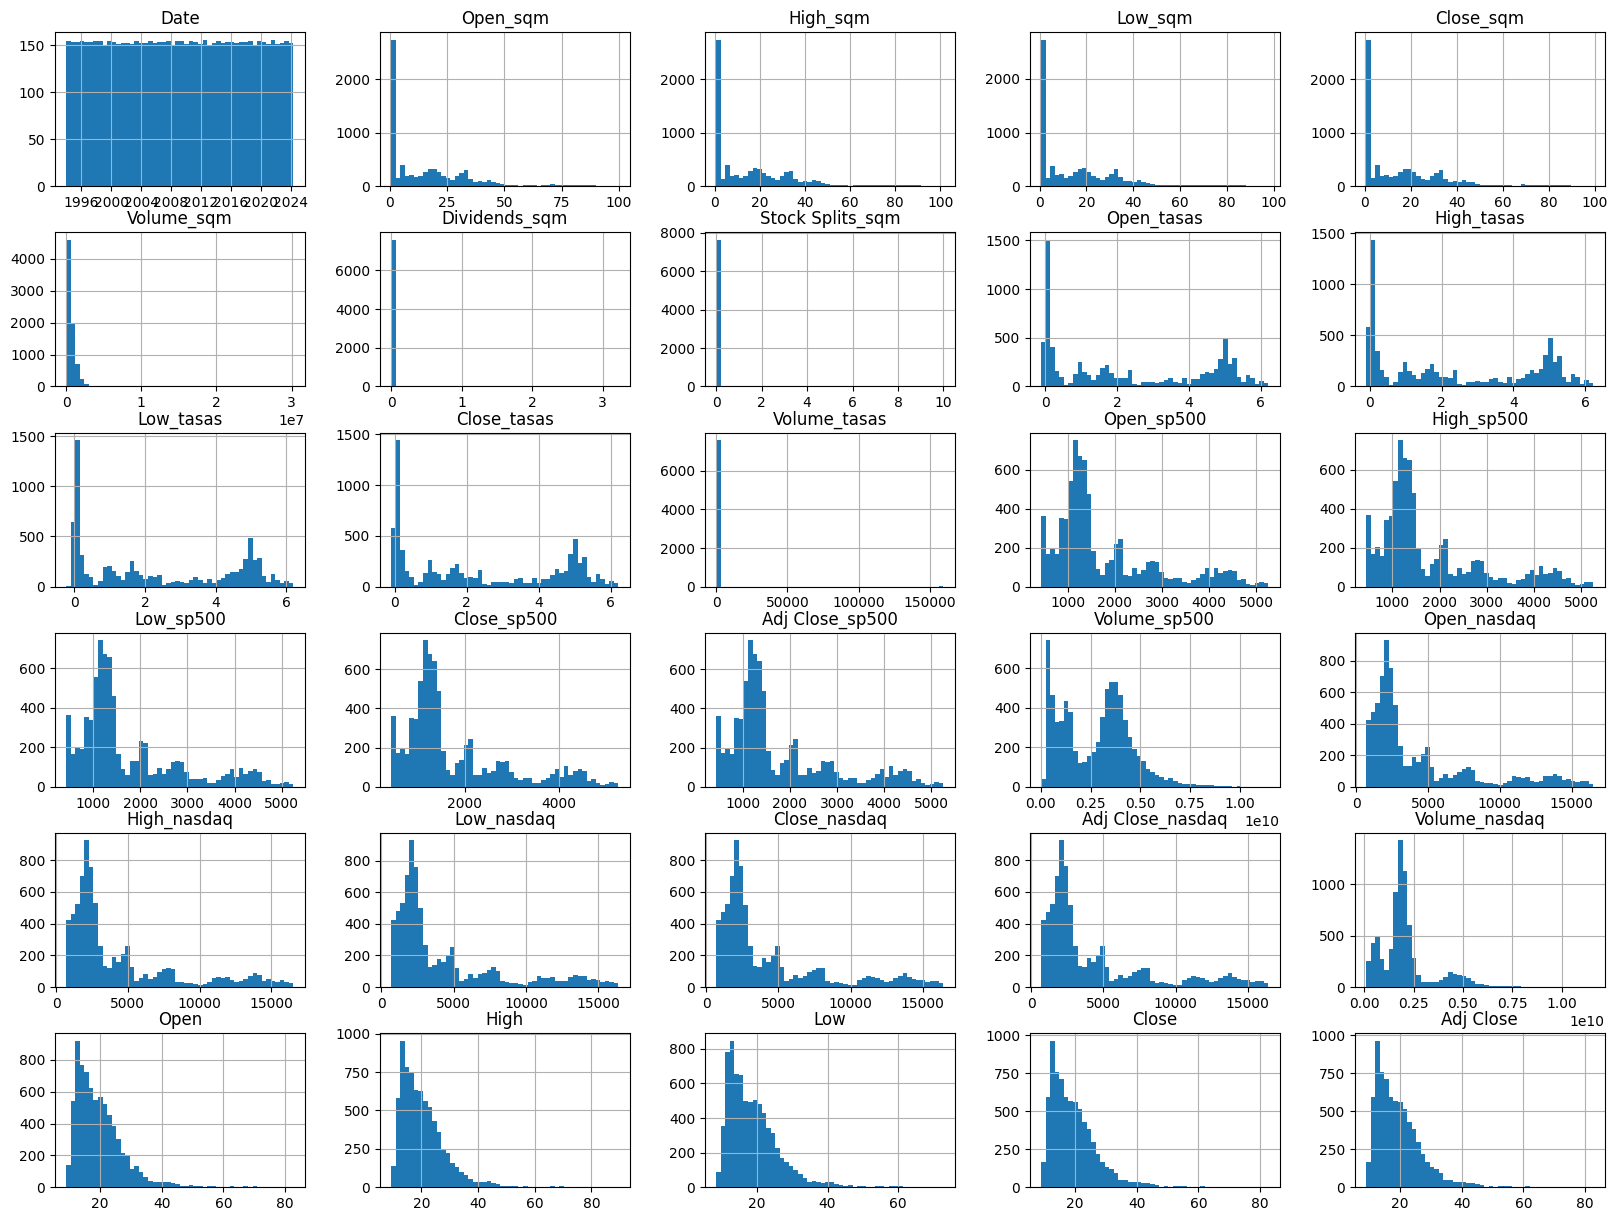

In [ ]:
# Histogramas para variables numéricas
df.hist(bins=50, figsize=(20,15))
plt.show()

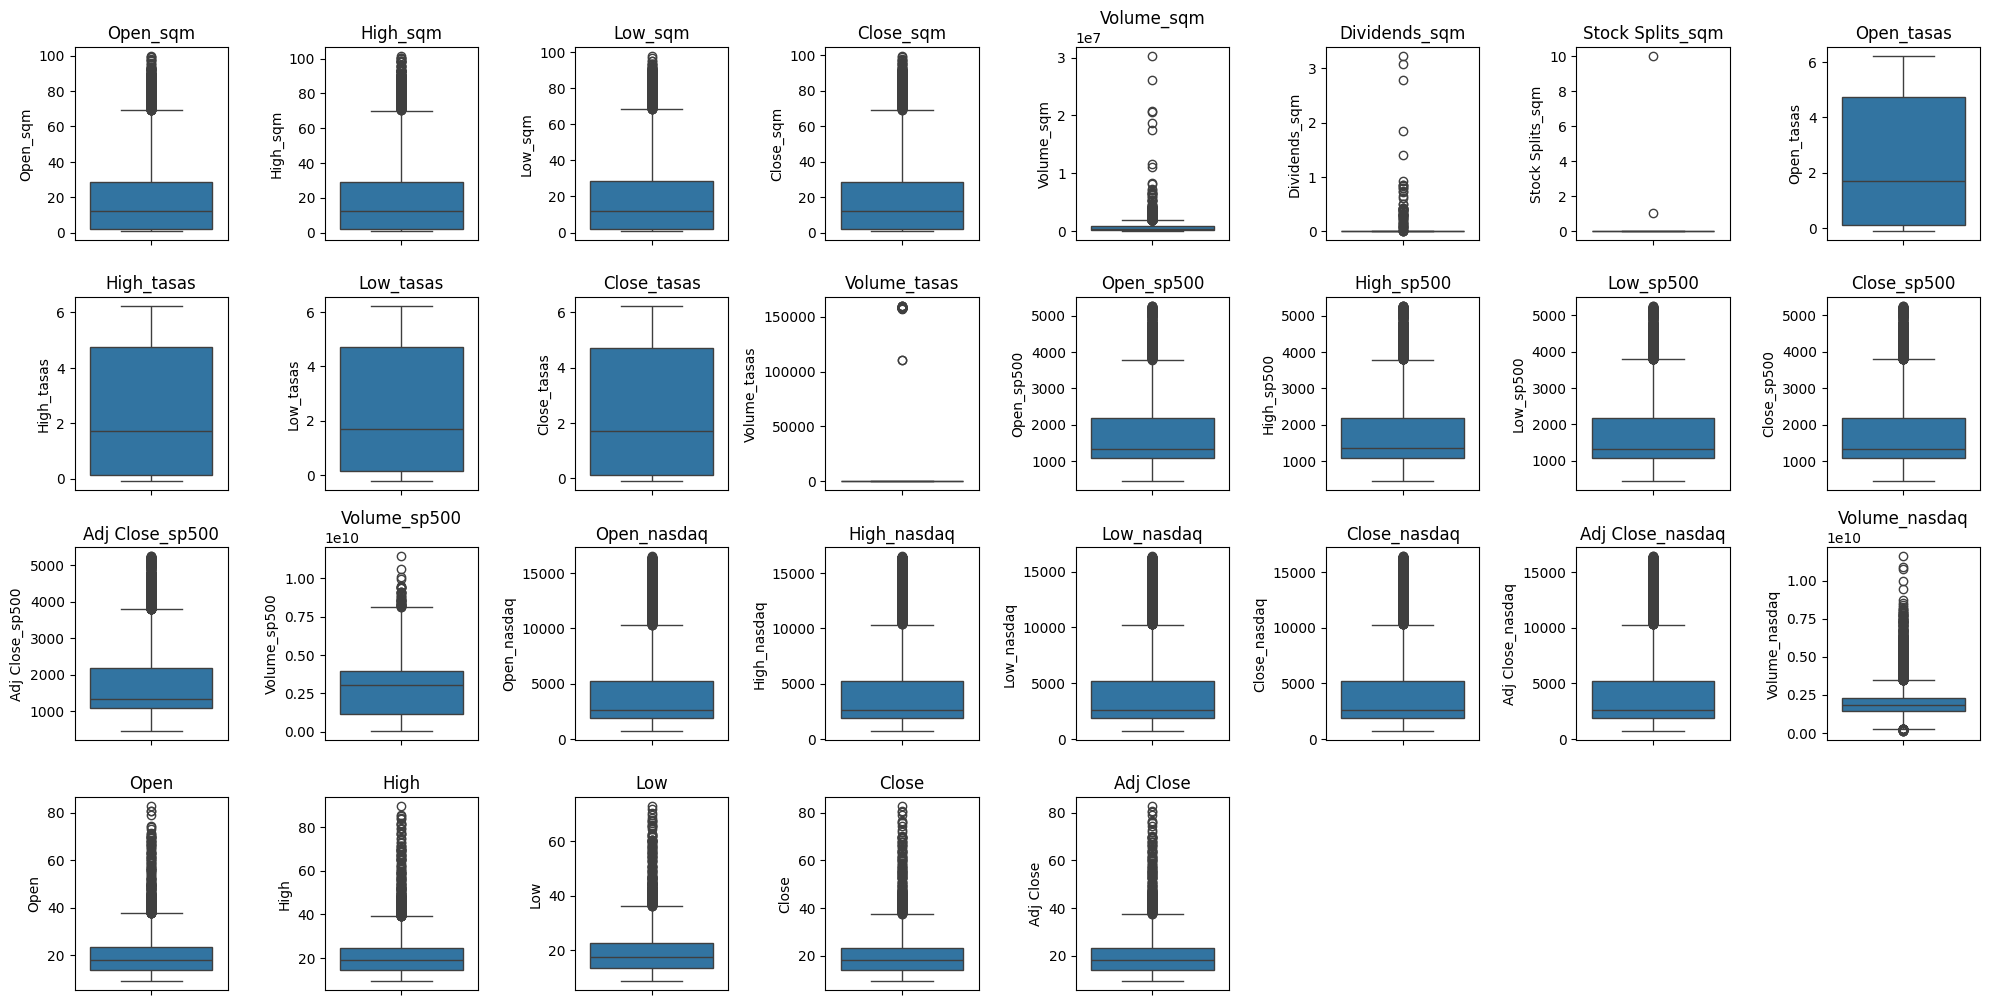

In [ ]:
import seaborn as sns

# Lista de variables a graficar
variables = ['Open_sqm', 'High_sqm', 'Low_sqm', 'Close_sqm', 'Volume_sqm',
             'Dividends_sqm', 'Stock Splits_sqm', 'Open_tasas', 'High_tasas',
             'Low_tasas', 'Close_tasas', 'Volume_tasas', 'Open_sp500',
             'High_sp500', 'Low_sp500', 'Close_sp500', 'Adj Close_sp500',
             'Volume_sp500', 'Open_nasdaq', 'High_nasdaq', 'Low_nasdaq',
             'Close_nasdaq', 'Adj Close_nasdaq', 'Volume_nasdaq', 'Open',
             'High', 'Low', 'Close', 'Adj Close']

plt.figure(figsize=(20, 10))

for i, var in enumerate(variables):
    plt.subplot(4, 8, i + 1)
    sns.boxplot(y=df[var])
    plt.title(var)

plt.tight_layout()
plt.show()


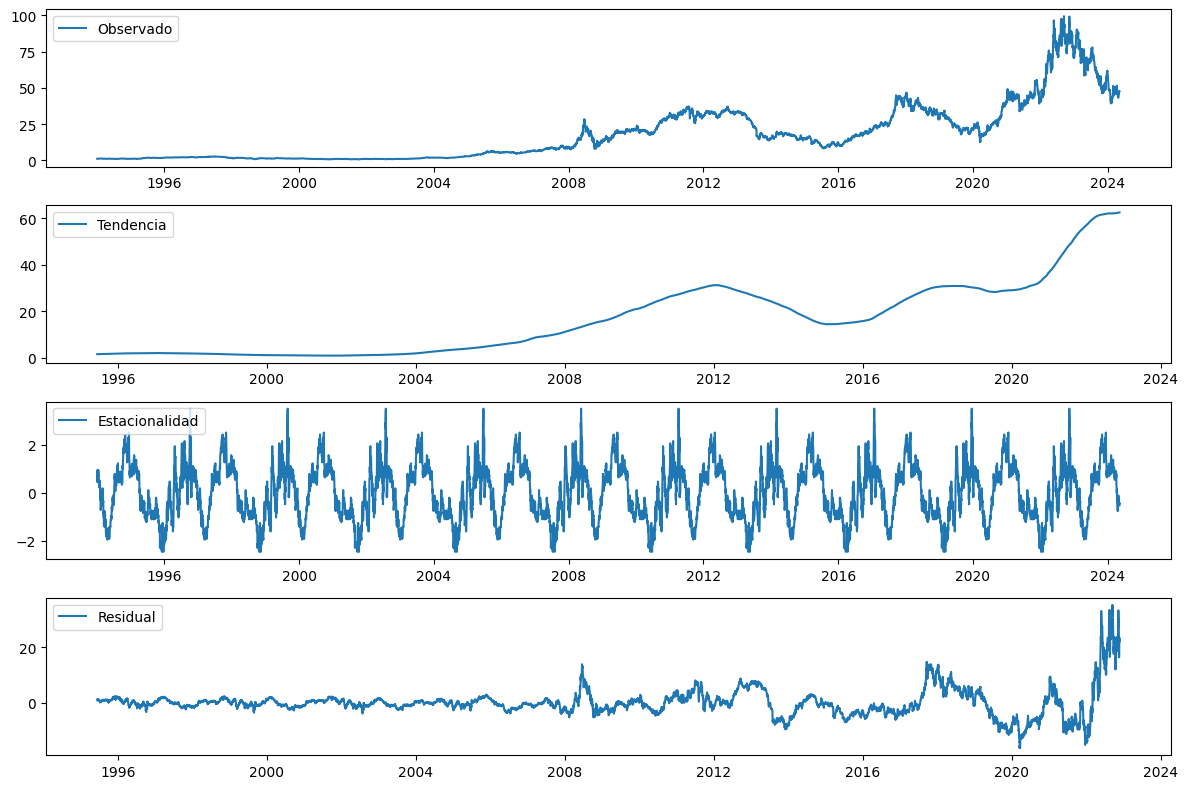

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Suponiendo que 'Close' es la columna que contiene tus datos de precios de cierre
# y que 'Date' es tu índice de fecha
df.index = df['Date']

# Descomposición de la serie temporal
result = seasonal_decompose(df['Close_sqm'], model='additive', period=730)  # Se asume un período de estacionalidad de 30 días

# Visualización de la descomposición
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(result.observed, label='Observado')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(result.trend, label='Tendencia')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(result.seasonal, label='Estacionalidad')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(result.resid, label='Residual')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
result.resid.mean()

0.0648465654128901

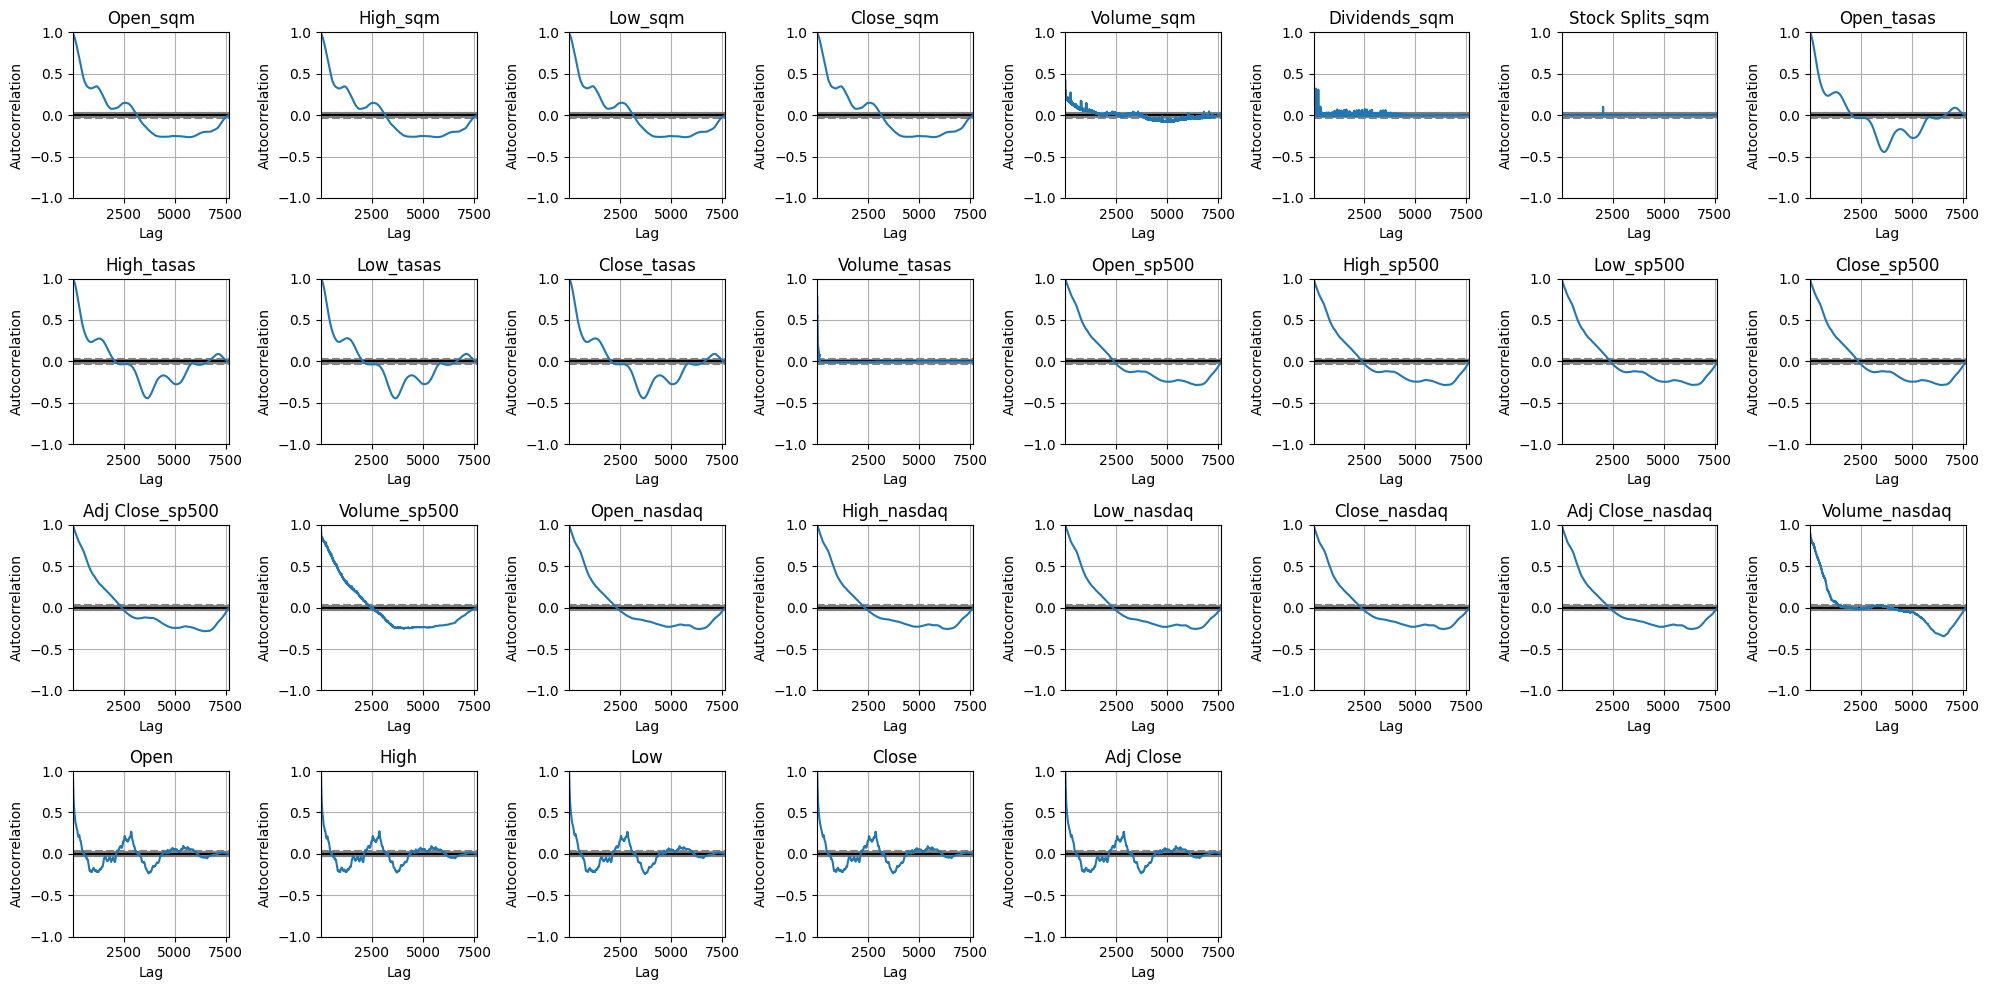

In [ ]:
from pandas.plotting import autocorrelation_plot

# Lista de variables a analizar la autocorrelación
variables = ['Open_sqm', 'High_sqm', 'Low_sqm', 'Close_sqm', 'Volume_sqm',
             'Dividends_sqm', 'Stock Splits_sqm', 'Open_tasas', 'High_tasas',
             'Low_tasas', 'Close_tasas', 'Volume_tasas', 'Open_sp500',
             'High_sp500', 'Low_sp500', 'Close_sp500', 'Adj Close_sp500',
             'Volume_sp500', 'Open_nasdaq', 'High_nasdaq', 'Low_nasdaq',
             'Close_nasdaq', 'Adj Close_nasdaq', 'Volume_nasdaq', 'Open',
             'High', 'Low', 'Close', 'Adj Close']

plt.figure(figsize=(20, 10))

for i, var in enumerate(variables):
    plt.subplot(4, 8, i + 1)
    autocorrelation_plot(df[var])
    plt.title(var)

plt.tight_layout()
plt.show()


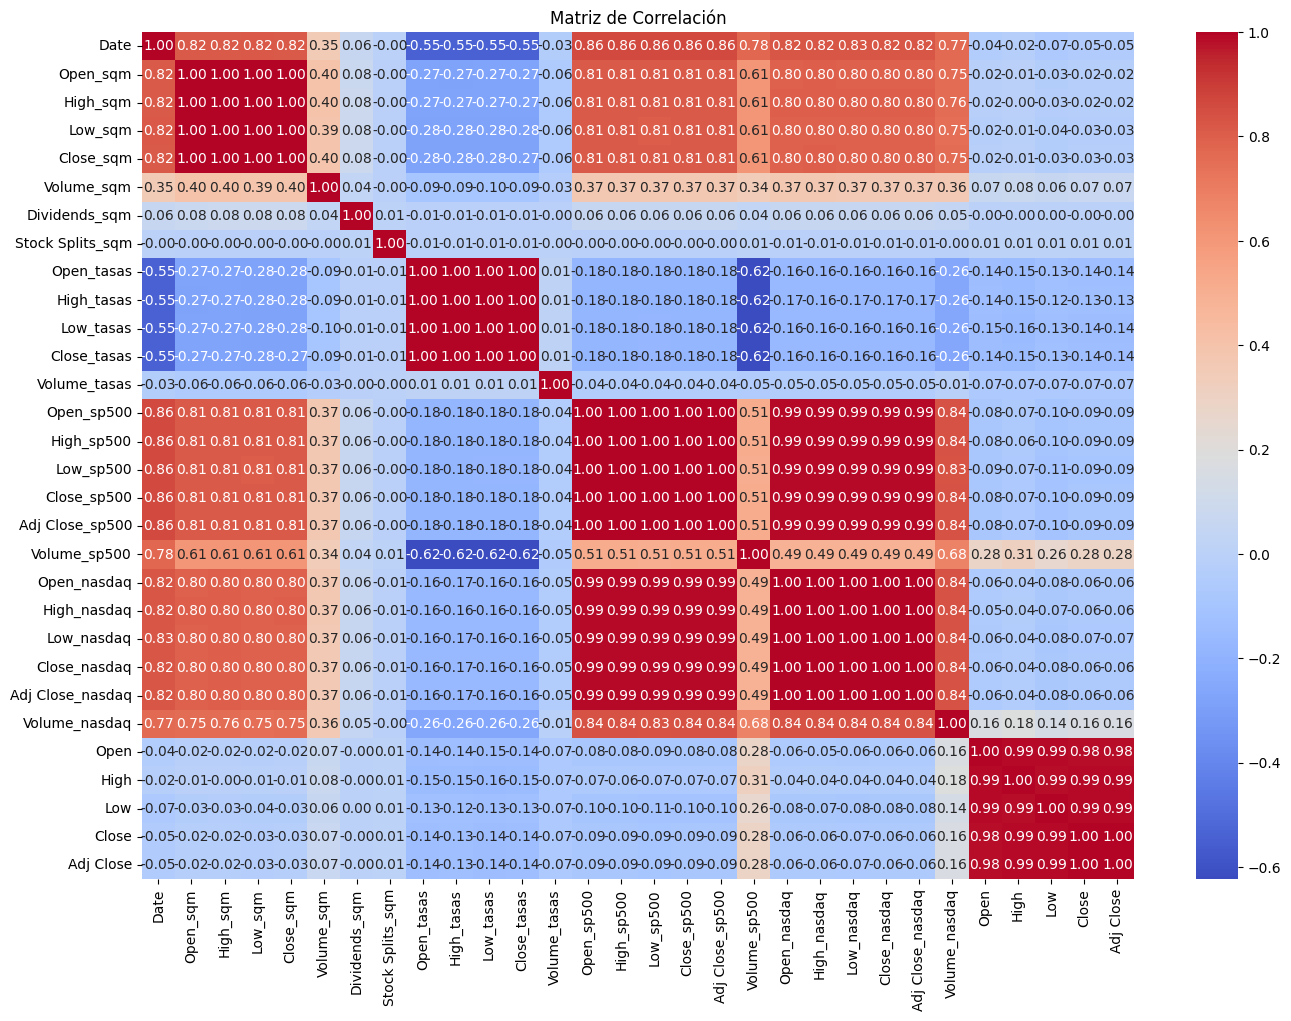

In [ ]:
# Calcular la matriz de correlación
corr_matrix = df.corr()

# Crear un mapa de calor para visualizar la matriz de correlación
plt.figure(figsize=(16, 11))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

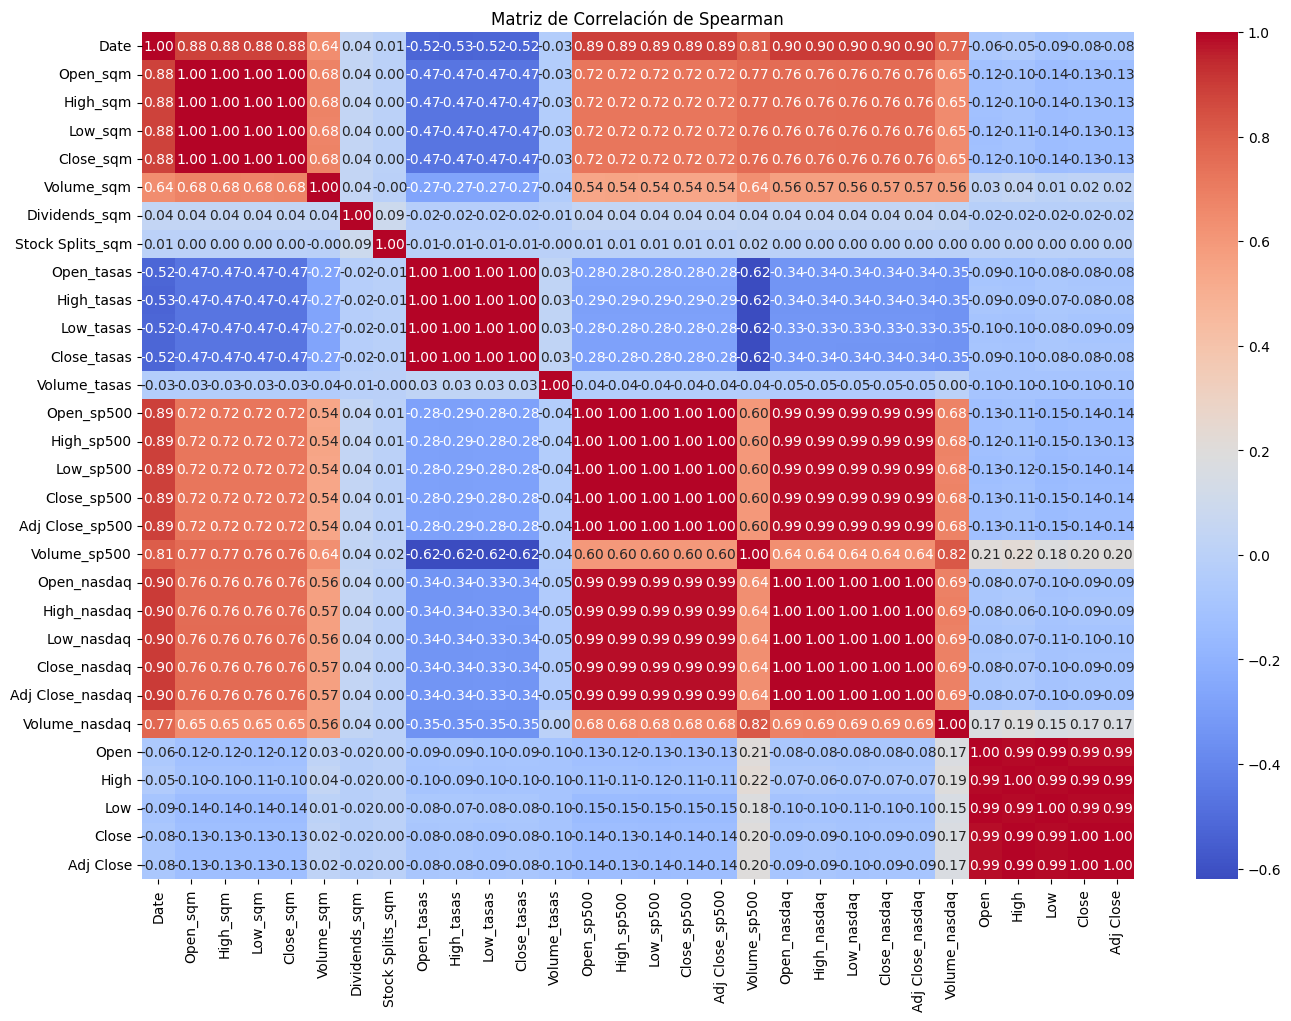

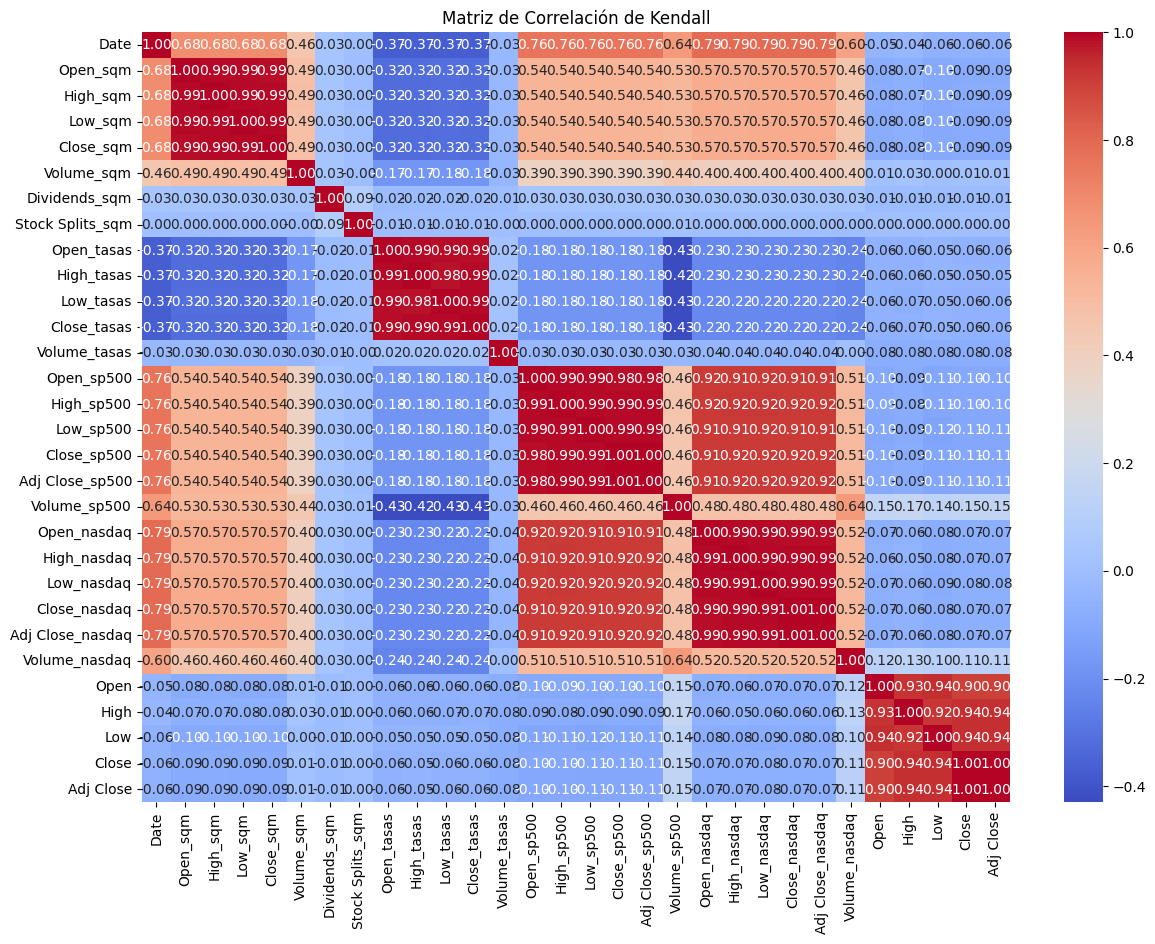

In [ ]:
from scipy.stats import spearmanr, kendalltau

# Calcular el coeficiente de correlación de Spearman
spearman_corr = df.corr(method='spearman')

# Calcular el coeficiente de correlación de Kendall
kendall_corr = df.corr(method='kendall')

# Visualizar la matriz de correlación de Spearman como un mapa de calor
plt.figure(figsize=(16, 11))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación de Spearman')
plt.show()

# Visualizar la matriz de correlación de Kendall como un mapa de calor
plt.figure(figsize=(14, 10))
sns.heatmap(kendall_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación de Kendall')
plt.show()


In [ ]:
df.head()

Date  Open_sqm  High_sqm   Low_sqm  Close_sqm  Volume_sqm  \
Date                                                                         
1994-01-03 1994-01-03  1.151877  1.175874  1.142278   1.166275      960245   
1994-01-04 1994-01-04  1.161475  1.161475  1.142277   1.151876      413881   
1994-01-05 1994-01-05  1.151877  1.161475  1.123079   1.147077      610038   
1994-01-06 1994-01-06  1.151877  1.151877  1.118281   1.118281      115024   
1994-01-07 1994-01-07  1.118280  1.118280  1.094283   1.094283      218751   

            Dividends_sqm  Stock Splits_sqm  Open_tasas  High_tasas  ...  \
Date                                                                 ...   
1994-01-03            0.0               0.0        3.01        3.04  ...   
1994-01-04            0.0               0.0        3.09        3.09  ...   
1994-01-05            0.0               0.0        3.08        3.08  ...   
1994-01-06            0.0               0.0        3.06        3.06  ...   
1994-01-07            0.0               0.0        3.04        3.04  ...   

            High_nasdaq  Low_nasdaq  Close_nasdaq  Adj Close_nasdaq  \
Date                                                                  
1994-01-03   777.289978  768.409973    770.760010        770.760010   
1994-01-04   774.780029  771.020020    774.280029        774.280029   
1994-01-05   778.210022  773.690002    778.049988        778.049988   
1994-01-06   781.210022  778.250000    780.409973        780.409973   
1994-01-07   783.390015  778.200012    782.940002        782.940002   

            Volume_nasdaq   Open   High    Low  Close  Adj Close  
Date                                                              
1994-01-03      253020000  11.28  13.42  11.28  12.57      12.57  
1994-01-04      298600000  12.87  12.87  11.81  11.91      11.91  
1994-01-05      349880000  11.47  11.47  10.37  10.94      10.94  
1994-01-06      349210000  11.47  11.74  10.34  11.27      11.27  
1994-01-07      330060000  11.47  12.14  10.00  10.96      10.96  

[5 rows x 30 columns]

In [ ]:
# Suponiendo que tu DataFrame se llame df y que 'Date' es el nombre de la columna
df.reset_index(drop=True, inplace=True)

In [ ]:
# Configurar pandas para mostrar todas las columnas
pd.set_option('display.max_columns', None)

In [ ]:
# Agregar componentes de la fecha como características
df['Day_of_week'] = df['Date'].dt.dayofweek  # Día de la semana (0 = lunes, 6 = domingo)
df['Month'] = df['Date'].dt.month  # Mes (1 = enero, 12 = diciembre)
df['Year'] = df['Date'].dt.year  # Año

In [ ]:
df.head()

Date  Open_sqm  High_sqm   Low_sqm  Close_sqm  Volume_sqm  \
0 1994-01-03  1.151877  1.175874  1.142278   1.166275      960245   
1 1994-01-04  1.161475  1.161475  1.142277   1.151876      413881   
2 1994-01-05  1.151877  1.161475  1.123079   1.147077      610038   
3 1994-01-06  1.151877  1.151877  1.118281   1.118281      115024   
4 1994-01-07  1.118280  1.118280  1.094283   1.094283      218751   

   Dividends_sqm  Stock Splits_sqm  Open_tasas  High_tasas  Low_tasas  \
0            0.0               0.0        3.01        3.04       3.01   
1            0.0               0.0        3.09        3.09       3.07   
2            0.0               0.0        3.08        3.08       3.06   
3            0.0               0.0        3.06        3.06       3.04   
4            0.0               0.0        3.04        3.04       3.01   

   Close_tasas  Volume_tasas  Open_sp500  High_sp500   Low_sp500  Close_sp500  \
0         3.03           0.0  466.510010  466.940002  464.359985   465.440002   
1         3.08           0.0  465.440002  466.890015  464.440002   466.890015   
2         3.07           0.0  466.890015  467.820007  465.920013   467.549988   
3         3.05           0.0  467.549988  469.000000  467.019989   467.119995   
4         3.01           0.0  467.089996  470.260010  467.029999   469.899994   

   Adj Close_sp500  Volume_sp500  Open_nasdaq  High_nasdaq  Low_nasdaq  \
0       465.440002     270140000   774.109985   777.289978  768.409973   
1       466.890015     326600000   771.429993   774.780029  771.020020   
2       467.549988     400030000   775.229980   778.210022  773.690002   
3       467.119995     365960000   780.359985   781.210022  778.250000   
4       469.899994     324920000   779.289978   783.390015  778.200012   

   Close_nasdaq  Adj Close_nasdaq  Volume_nasdaq   Open   High    Low  Close  \
0    770.760010        770.760010      253020000  11.28  13.42  11.28  12.57   
1    774.280029        774.280029      298600000  12.87  12.87  11.81  11.91   
2    778.049988        778.049988      349880000  11.47  11.47  10.37  10.94   
3    780.409973        780.409973      349210000  11.47  11.74  10.34  11.27   
4    782.940002        782.940002      330060000  11.47  12.14  10.00  10.96   

   Adj Close  Day_of_week  Month  Year  
0      12.57            0      1  1994  
1      11.91            1      1  1994  
2      10.94            2      1  1994  
3      11.27            3      1  1994  
4      10.96            4      1  1994

# 3- Desarrollo de modelo predictivo

**Entrenar modelo**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Suponiendo que df es tu DataFrame con todas las características y la columna 'Close_sqm' a predecir
X = df.drop(columns=['Date', 'Close_sqm'])  # Características, excluyendo 'Date' y 'Close_sqm'
y = df['Close_sqm']  # Variable a predecir

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo XGBRegressor
model = XGBRegressor()

# Entrenar el modelo
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

validacion cruzada

In [ ]:
from sklearn.model_selection import cross_val_score

# Suponiendo que X e y ya están definidos y tienes tu modelo XGBRegressor en 'model'

# Realizar validación cruzada con 5 folds
scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5)

# Convertir los scores negativos a positivos y calcular el RMSE promedio
rmse_scores = np.sqrt(-scores)
print(f'RMSE promedio en validación cruzada: {np.mean(rmse_scores)}')

# Calcular el R^2 promedio en validación cruzada
r2_scores = cross_val_score(model, X, y, scoring='r2', cv=5)
print(f'R^2 promedio en validación cruzada: {np.mean(r2_scores)}')


RMSE promedio en validación cruzada: 3.8154899346567213
R^2 promedio en validación cruzada: 0.8065535175940279


**Métricas**

MSE en conjunto de entrenamiento: 0.010152225265822136
RMSE en conjunto de entrenamiento: 0.10075825160165362
R^2 en conjunto de entrenamiento: 0.9999732927883538
MSE en conjunto de prueba: 0.27933544588943826
RMSE en conjunto de prueba: 0.5285219445675253
R^2 en conjunto de prueba: 0.9992988888456246
Características importantes:
Open_sqm: 0.004047616850584745
High_sqm: 0.48044222593307495
Low_sqm: 0.5133881568908691
Volume_sqm: 3.8412959838751704e-05
Dividends_sqm: 6.27796816843329e-06
Stock Splits_sqm: 4.125603481952567e-06
Open_tasas: 4.360342427389696e-05
High_tasas: 5.4845604608999565e-05
Low_tasas: 2.5996414478868246e-05
Close_tasas: 8.32953883218579e-05
Volume_tasas: 4.355249984655529e-06
Open_sp500: 5.2033115935046226e-05
High_sp500: 6.679743091808632e-05
Low_sp500: 2.688615677470807e-05
Close_sp500: 3.658205969259143e-05
Adj Close_sp500: 0.0
Volume_sp500: 2.421890530968085e-05
Open_nasdaq: 6.165476224850863e-05
High_nasdaq: 7.801563333487138e-05
Low_nasdaq: 8.851459278957918e-

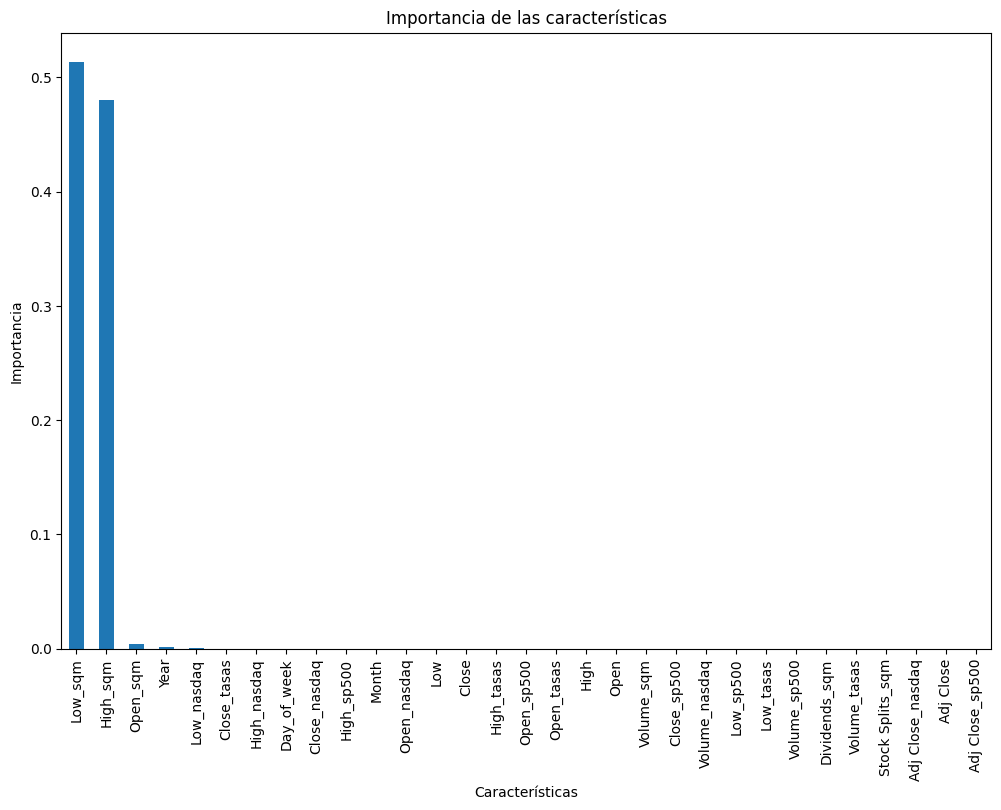

In [ ]:
# Hacer predicciones en el conjunto de entrenamiento
y_pred_train = model.predict(X_train)

# Calcular el error cuadrático medio (MSE) en el conjunto de entrenamiento
mse_train = mean_squared_error(y_train, y_pred_train)
print(f'MSE en conjunto de entrenamiento: {mse_train}')

# Calcular el RMSE en el conjunto de entrenamiento
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print(f'RMSE en conjunto de entrenamiento: {rmse_train}')

# Calcular el R^2 en el conjunto de entrenamiento
r2_train = r2_score(y_train, y_pred_train)
print(f'R^2 en conjunto de entrenamiento: {r2_train}')

# Hacer predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular el error cuadrático medio (MSE) en el conjunto de prueba
mse_test = mean_squared_error(y_test, y_pred)
print(f'MSE en conjunto de prueba: {mse_test}')

# Calcular el RMSE en el conjunto de prueba
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE en conjunto de prueba: {rmse_test}')

# Calcular el R^2 en el conjunto de prueba
r2_test = r2_score(y_test, y_pred)
print(f'R^2 en conjunto de prueba: {r2_test}')

# También puedes imprimir las características más importantes para el modelo
print("Características importantes:")
for feature, importance in zip(X.columns, model.feature_importances_):
    print(f"{feature}: {importance}")

# Crear el gráfico de barras para las características importantes
feature_importance = pd.Series(model.feature_importances_, index=X.columns)
feature_importance_sorted = feature_importance.sort_values(ascending=False)
plt.figure(figsize=(12, 8))
feature_importance_sorted.plot(kind='bar')
plt.title('Importancia de las características')
plt.xlabel('Características')
plt.ylabel('Importancia')
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Crear el modelo XGBRegressor
model = XGBRegressor()

# Realizar la búsqueda de hiperparámetros con validación cruzada
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo y sus hiperparámetros
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Entrenar el mejor modelo con todos los datos de entrenamiento
best_model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test)

# Calcular el MSE en el conjunto de prueba
mse = mean_squared_error(y_test, y_pred)
print(f'MSE en conjunto de prueba: {mse}')

# También puedes imprimir las características más importantes para el modelo
print("Características importantes:")
for feature, importance in zip(X.columns, best_model.feature_importances_):
    print(f"{feature}: {importance}")


MSE en conjunto de prueba: 0.2267290419556382
Características importantes:
Open_sqm: 0.006243454292416573
High_sqm: 0.5251290202140808
Low_sqm: 0.4671396315097809
Volume_sqm: 5.560791032621637e-05
Dividends_sqm: 7.322529654629761e-06
Stock Splits_sqm: 0.0
Open_tasas: 6.343321729218587e-05
High_tasas: 3.493495023576543e-05
Low_tasas: 5.426209099823609e-05
Close_tasas: 6.494673289125785e-05
Volume_tasas: 3.095406100328546e-06
Open_sp500: 8.209797670133412e-05
High_sp500: 6.438604759750888e-05
Low_sp500: 5.450555181596428e-05
Close_sp500: 5.9097143093822524e-05
Adj Close_sp500: 0.0
Volume_sp500: 4.4418920879252255e-05
Open_nasdaq: 7.259263657033443e-05
High_nasdaq: 5.6325181503780186e-05
Low_nasdaq: 5.6240758567582816e-05
Close_nasdaq: 0.00010023277718573809
Adj Close_nasdaq: 0.0
Volume_nasdaq: 4.670390990213491e-05
Open: 5.206728383200243e-05
High: 5.429965676739812e-05
Low: 0.00013345706975087523
Close: 6.08097980148159e-05
Adj Close: 0.0
Day_of_week: 7.130161247914657e-05
Month: 2.6054

In [ ]:
best_params

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}